- Description: Changi Taxiway Planning
- Author: ZHANG Yuhao
- Date: 2020-08-12 12:07:00

# Part 1: Changi Aiport Map Data Processing
- Extract Nodes and Links from OpenStreetMap file (OSM file is pre-processed with JSOM software)
- Visualise Nodes and Links
- Map Gate ID and Gate Names
- Map Node ID and Node Index
- Build Node Connectivity and Link Connectivity Dictionary
- Build Node Distance Matrix
- Calculate Shortest Paths between Two Nodes 
- Data Exploration: find a path between two node using random walk or shortest path algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from io import StringIO

%matplotlib inline
pd.set_option('display.max_columns', None)

OSM_FILE_PATH = "filtered.osm"
MAP_IMAGE_PATH = "map_image.png"

### Load OSM file as XML

In [2]:
f = open(OSM_FILE_PATH)
xml = f.read()
f.close()

etree = ET.parse(StringIO(xml)) # create an ElementTree object 
root = etree.getroot()
root.attrib

{'version': '0.6', 'generator': 'JOSM'}

### Extract Nodes from OSM file

In [3]:
# extract all nodes
df_list = []
for node in root.iter('node'):
    attrib_dict = node.attrib
    # exclude nodes that have been deleted
    if 'action' in attrib_dict and attrib_dict['action'] == 'delete':
        pass
    else:
        for tag in node.iter('tag'):
            # extract node information
            key, value = tag.attrib['k'], tag.attrib['v']
            if key == 'aeroway' or key == 'ref':
                attrib_dict[key] = value
        node_df  = pd.DataFrame([attrib_dict], columns=attrib_dict.keys())
        df_list.append(node_df)
        
node_df = pd.concat(df_list, ignore_index=True, sort=True).rename(columns={"id": "node_id"}).set_index("node_id")

6 types of nodes can be extracted using the tag information:
- Terminal Gates: each date should be mapped to a parking position.
- Parking Positions are the starting nodes for departure flights and end nodes for arrival flights
- Taxiway Nodes
- Runway Nodes are end node for departure flights and start node for arrival flights
    - Arrival Runway Nodes
    - Departure Runway Nodes
- Holding Positions: Holding position markings occur on each taxiway leading to a runway in order to prevent taxiing aircraft and vehicles penetrating the designated protection zone either side of a runway, which needs to be kept clear during runway use

#### In this project, we do not need to consider arrival runway nodes and holding positions.

In [4]:
# convert lontitude and latitude columns to float type
node_df.lon = node_df.lon.astype(float)
node_df.lat = node_df.lat.astype(float)

In [5]:
# bounding box for the map
BBox = ((node_df.lon.min(), node_df.lon.max(),      
         node_df.lat.min(), node_df.lat.max()))

# Use the bounding box coordiantes to export background map on OpenStreetMap website
BBox

(103.97755712003, 103.9990453, 1.329059, 1.3817661)

In [6]:
# extract types of nodes
gate_df = node_df[node_df['aeroway'] == "gate"]
parking_df = node_df[node_df['aeroway'] == "parking_position"]
holding_df = node_df[node_df['aeroway'] == "holding_position"]
taxiway_df = node_df[node_df['aeroway'].isnull()]
arr_runway_df = node_df[node_df['aeroway'] == "arrival_runway"]
dep_runway_df = node_df[node_df['aeroway'] == "departure_runway"]

print("Total number of nodes:", node_df.shape[0])
print("Number of gates:", gate_df.shape[0])
print("Number of parking positions:", parking_df.shape[0])
print("Number of holding positions:", holding_df.shape[0])
print("Number of taxiway nodes:", taxiway_df.shape[0])
print("Number of arrival runway nodes:", arr_runway_df.shape[0])
print("Number of departure runway nodes:", dep_runway_df.shape[0])

Total number of nodes: 1451
Number of gates: 114
Number of parking positions: 112
Number of holding positions: 8
Number of taxiway nodes: 1205
Number of arrival runway nodes: 4
Number of departure runway nodes: 6


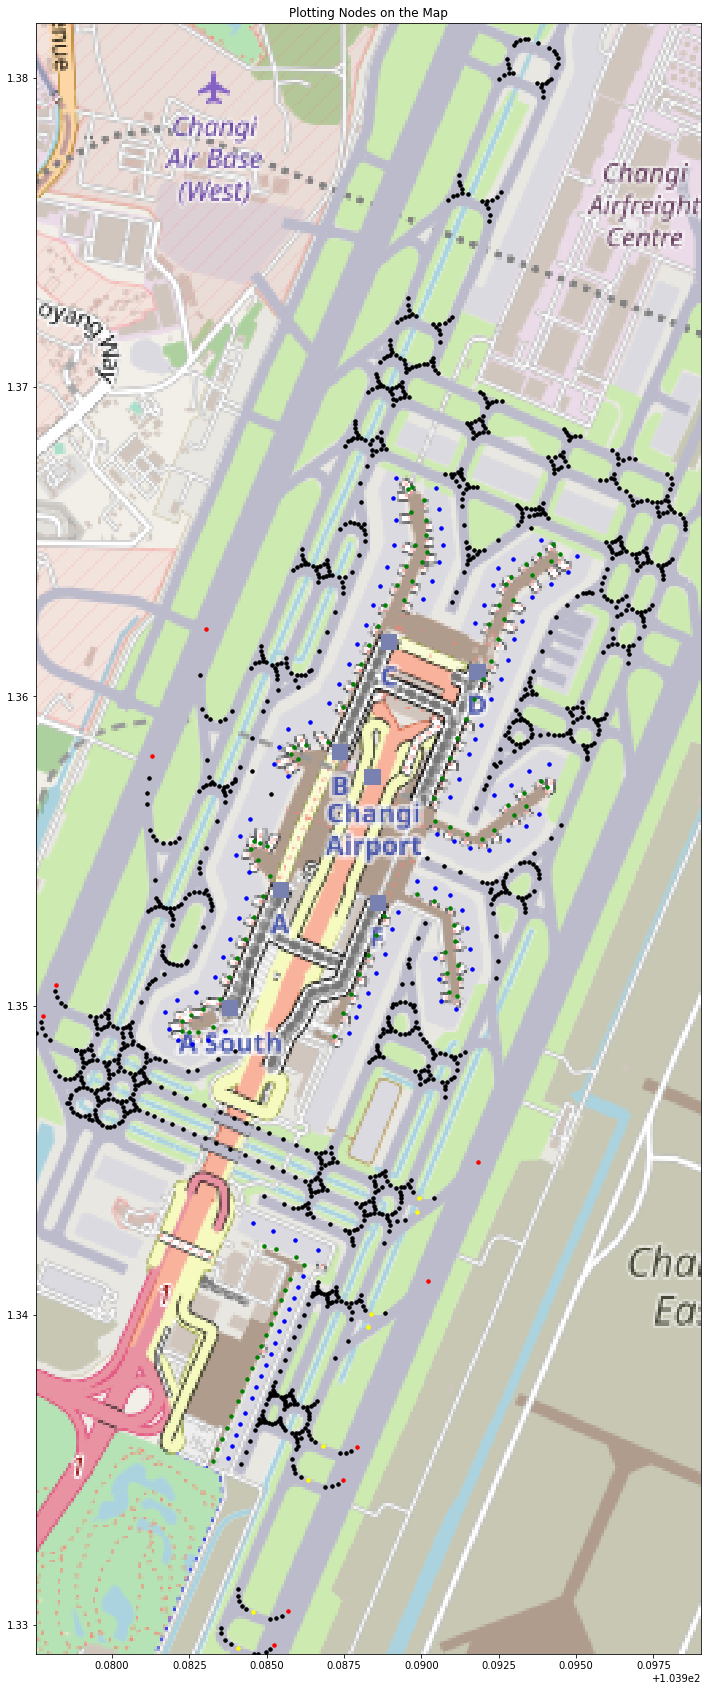

In [7]:
# plot extracted nodes on a map
image_map = plt.imread(MAP_IMAGE_PATH)
fig, ax = plt.subplots(figsize=(30, 30))
ax.scatter(parking_df.lon, parking_df.lat, zorder=1, alpha= 1, c='b', s=12)
ax.scatter(gate_df.lon, gate_df.lat, zorder=1, alpha= 1, c='green', s=12)
ax.scatter(holding_df.lon, holding_df.lat, zorder=1, alpha= 1, c='yellow', s=12)
ax.scatter(taxiway_df.lon, taxiway_df.lat, zorder=1, alpha= 1, c='black', s=12)
ax.scatter(arr_runway_df.lon, arr_runway_df.lat, zorder=1, alpha= 1, c='red', s=12)
ax.scatter(dep_runway_df.lon, dep_runway_df.lat, zorder=1, alpha= 1, c='red', s=12)
        
ax.set_title('Plotting Nodes on the Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

Map Legend
- Green Dots: Terminal Gates
- Blue Dots: Parking Positions
- Black Dots: Taxiway Nodes
- Red Dots: Departure and Arrival Runway Nodes
- Yellow Dots: Holding Positions

### Extract Ways from OSM file
A way is an ordered list of nodes which normally also has at least one tag or is included within a Relation.
The member list contains the nodes in a way and are arranged in sequence, that is, the first node is connected to the second, the second is connected to the first and the third.

In [8]:
# extract all ways
df_list = []
for way in root.iter('way'):
    attrib_dict = way.attrib
    if 'action' in attrib_dict and attrib_dict['action'] == 'delete':
        pass
    else:
        tag_dict = {}
        member_list = []
        
        # get tag information such as way type (e.g. Taxiway) and name (e.g. E2)
        for tag in way.iter('tag'):
            key, value = tag.attrib['k'], tag.attrib['v']
            tag_dict[key] = value    
            
        for member in way.iter('nd'):
            member_list.append(str(member.attrib['ref']))
        
        tag_dict["members"] = member_list   
        tag_dict["way_id"] = attrib_dict["id"]
        way_df  = pd.DataFrame([tag_dict], columns=tag_dict.keys())
        df_list.append(way_df)
        
way_df = pd.concat(df_list, ignore_index=True, sort=True).set_index("way_id")

In [9]:
print("Total number of ways:", way_df.shape[0])

Total number of ways: 899


### Construct Node Connectivity Dictionary 
Use Node IDs as key and value

In [10]:
node_connectivity = {}
node_way_list = {} # store the ways that a node is in

In [11]:
# iterate through all ways
for index, row in way_df.iterrows():
    way_id = index
    members = row['members']
    way_type = row['aeroway']
    for i in range(len(members)):
        node_id = members[i]
        # add way_id to the node_way_list
        if node_id not in node_way_list:
            node_way_list[node_id] = [way_id]
        else:
            node_way_list[node_id].append(way_id)
                
        # add connected node id to node_connectiviy
        if i+1 <= len(members)-1:
            next_node_id = members[i+1]
            
            if way_type != "arrival_runway":
                if node_id not in node_connectivity:
                    node_connectivity[node_id] = [next_node_id]
                else:
                    node_connectivity[node_id].append(next_node_id)
            
            # add connectivity in reverse direction
            if way_type != "departure_runway":
                if next_node_id not in node_connectivity:
                    node_connectivity[next_node_id] = [node_id]
                else:
                    node_connectivity[next_node_id].append(node_id)

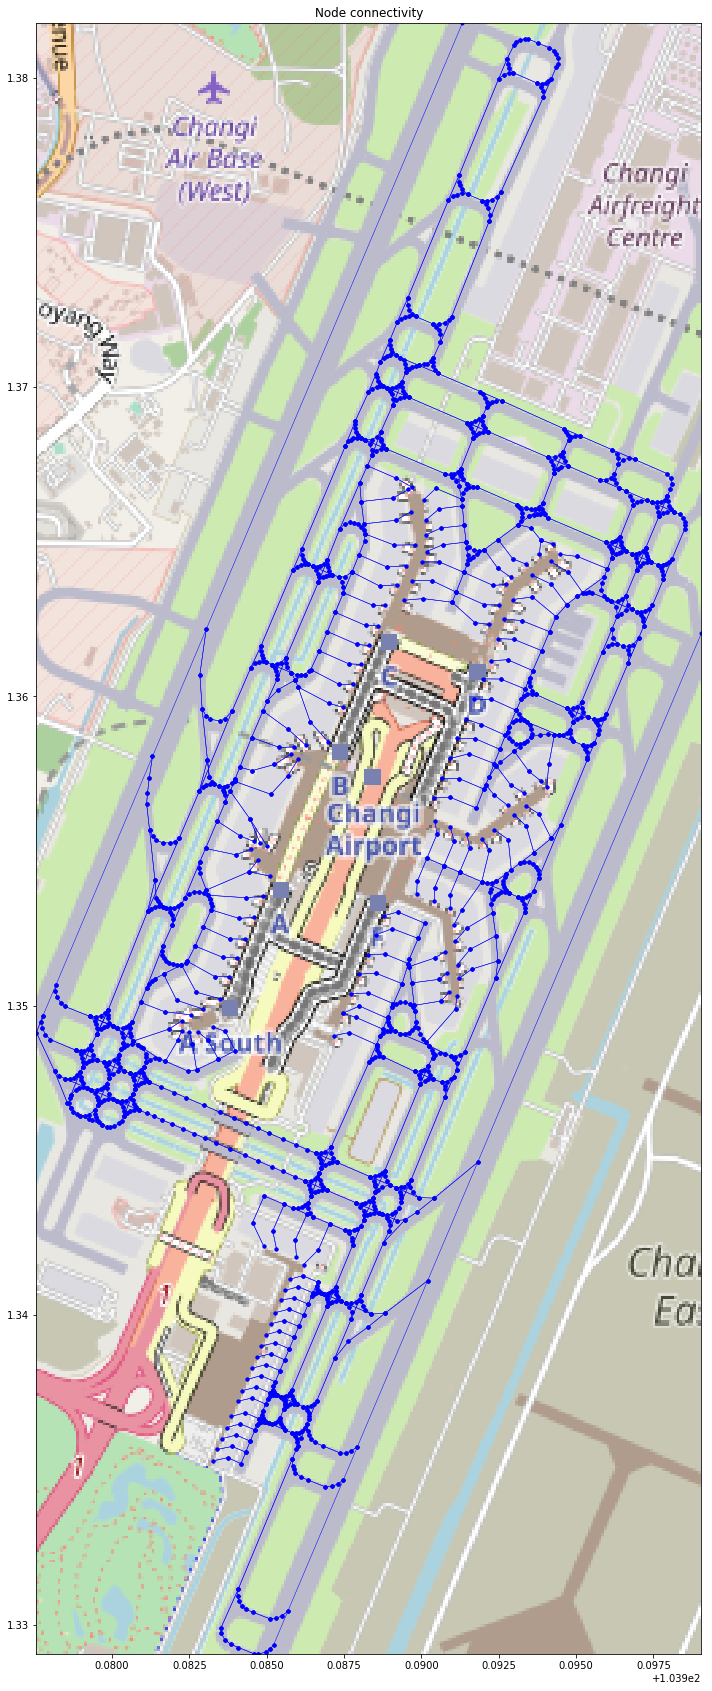

In [12]:
# plot node connectivity graph
image_map = plt.imread(MAP_IMAGE_PATH)
fig, ax = plt.subplots(figsize=(30, 30))
for c_node in node_connectivity.keys():
    connected_nodes = node_connectivity[c_node]
    for connected_id in connected_nodes:
        way_lon, way_lat =  [], []
        node = node_df.loc[c_node, ['lat', 'lon']]
        way_lon.append(node.lon)
        way_lat.append(node.lat)

        connected_node = node_df.loc[connected_id, ['lat', 'lon']]
        way_lon.append(connected_node.lon)
        way_lat.append(connected_node.lat)

        plt.plot(way_lon, way_lat, linewidth=0.5, marker='o', color='blue', markersize=3)  
    
ax.set_title('Node connectivity')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

### Mapping Gate IDs and Gate Names

In [13]:
gate_ref2id = {}

for index, row in gate_df.iterrows():
    gate_id = index
    gate_num = row["ref"]   
    
    if len(gate_num) > 3: #A6-A8
        gate_ref2id["A6"] = gate_id
        gate_ref2id["A7"] = gate_id
        gate_ref2id["A8"] = gate_id
    else:
        gate_ref2id[gate_num] = gate_id

In [14]:
# runway nodes
dep_runway = list(dep_runway_df.index.values)
print("A departing aircraft can end at either of the following departure runway nodes:")
print(dep_runway)

arr_runway = list(arr_runway_df.index.values)
print("An arriving aircraft can start from either of the following arrival runway nodes:")
print(arr_runway)

A departing aircraft can end at either of the following departure runway nodes:
['-104153', '-104223', '250319877', '250319909', '250319964', '1838409833']
An arriving aircraft can start from either of the following arrival runway nodes:
['250080423', '1204029064', '1838411243', '1838411368']


In the project, we limit the scope of planning to departure aircraft therefore we do not consider arrival aircraft. A departing aircraft's final destination is one of its departure runway nodes. In the optimization, we will only choose one node as the destination for simplicity.

In [15]:
# terminal gates list
gate_list = list(gate_ref2id.keys())
print("Terminal Gates:", gate_list)

Terminal Gates: ['A20', 'A19', 'A21', 'A3', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'F60', 'A18', 'A17', 'A16', 'F59', 'A15', 'A14', 'F37', 'F58', 'F42', 'F36', 'A13', 'F56', 'F41', 'F35', 'A12', 'F54', 'F40', 'F34', 'A11', 'F52', 'F33', 'A10', 'F50', 'F32', 'F31', 'A9', 'F30', 'A6', 'A7', 'A8', 'A5', 'A4', 'A1', 'A2', 'E4', 'E3', 'E5', 'E2', 'E1', 'E6', 'E10', 'E7', 'E20', 'E11', 'E8', 'E12', 'E22', 'E24', 'E26', 'E27', 'E28', 'D40', 'D41', 'D42', 'D30', 'D44', 'D32', 'C1', 'D46', 'C11', 'C20', 'C13', 'D35', 'D47', 'C22', 'D36', 'D48', 'C15', 'D49', 'D37', 'C16', 'C23', 'D38', 'C17', 'C18', 'C24', 'C19', 'C25', 'C26', 'G18', 'G17', 'G16', 'G14', 'G13', 'G12', 'G11', 'G10', 'G9', 'G8', 'G7', 'G6', 'G5', 'G4', 'G3', 'G2', 'G1', 'G21', 'G20', 'G19', 'G15', 'D34']


### Map Node IDs and Indices

In [16]:
node_id2idx = {}
node_idx2id = {}
idx = 0
for id_ in list(node_df.index.values):
    node_idx2id[idx] = id_
    node_id2idx[id_] = idx
    idx += 1

### Construct Link Connectivity Dictionary
Consider sharp turn angle constraint

In [17]:
import itertools
import random
from math import radians, cos, sin, asin, sqrt, acos, pi

In [18]:
# calculate distance between two points given lon and lat
def path_distance(start_node_id, end_node_id): 
    start_node = node_df.loc[start_node_id, ['lat', 'lon']]
    lat1, lon1 = start_node.lat, start_node.lon           
    end_node = node_df.loc[end_node_id, ['lat', 'lon']]
    lat2, lon2 = end_node.lat, end_node.lon      
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result in meters 
    return(c * r) * 1000

In [19]:
# calculate angle from point 1-2 to point 2-3 given lon and lat
def turn_angle(node_1, node_2, node_3):  
    # calculate three sides of the triangle
    a = path_distance(node_1, node_2)
    b = path_distance(node_2, node_3)
    c = path_distance(node_1, node_3)
    
    # approximate the angle using law of cosine
    rad = acos((a*a + b*b - c*c)/(2*a*b))
    angle = rad * 180 /pi
    return angle

In [20]:
# TEST 
prev_node_id = "6373463658"
curr_node_id = "250320291"
next_node_id = "1838411223"

angle = turn_angle(prev_node_id, curr_node_id, next_node_id)
print("Turn angle:", angle)

Turn angle: 19.689106362468507


In [21]:
# return way id given two connected nodes
# two connected nodes reside on one and only one way at the same time
def way_given_nodes(node1, node2): 
    way_list1 = node_way_list[node1]
    way_list2 = node_way_list[node2]
    common_list = list(set(way_list1) & set(way_list2))
    if len(common_list) == 0:
        return None
    else:
        return common_list[0]

In [22]:
# construct link connectivity dictionary
link_connectivity = {}
turn = {}

for node in node_connectivity.keys():
    connected_nodes = node_connectivity[node]
    
    if len(connected_nodes) >= 2:
        # get all pairs from the list  
        pair_index_list = list(itertools.permutations(range(len(connected_nodes)), 2))
        for pair in pair_index_list:
            (i1, i2) = pair
            prev_node, next_node = connected_nodes[i1], connected_nodes[i2]         
            link1 = way_given_nodes(prev_node, node)
            link2 = way_given_nodes(node, next_node)
            
            if link1 != link2 and turn_angle(prev_node, node, next_node) >= 70:
                if link1 not in link_connectivity:
                    link_connectivity[link1] = [link2]
                else:
                    link_connectivity[link1].append(link2)
                
                turn[(prev_node, node, next_node)] = 1

In [23]:
# TEST
test_link = "23161590"
print(link_connectivity[test_link])

['-105568', '173010526']


In [24]:
# traverse via a link from one end to the other
def traverse_link(from_node, link):
    members = way_df.loc[link, ['members']].values.tolist()[0]
    if members[0] == from_node:
        return members[-1], False
    else:
        # reverse direction
        return members[0], True

### Random Walk to find a path for departure/arrival flight

In [25]:
way_df.loc['-106037', ['aeroway']].values.tolist()[0]

'arrival_runway'

In [26]:
# random walk to find a path from start to any node in the end nodes list
def random_walk(gate, is_departure=True, steps=1000, allow_cycle=False):
    # initialization
    route = []
    direction = []
    gate_node_id = gate_ref2id[gate]
    
    if is_departure:
        # departure flight starts at gate
        start_link = node_way_list[gate_node_id][0]
        start_node = gate_node_id
    else:
        # arrival flight starts at arrival runway
        start_node = random.choice(arr_runway)
        way_list = node_way_list[start_node]
        for link in way_list:
            if way_df.loc[link, ['aeroway']].values.tolist()[0] != "arrival_runway":
                start_link = link
                break
    
    curr_node = start_node
    curr_link = start_link
    route.append(start_link)
    
    # iterations
    for i in range(steps):   
        # check if destination is at the end of the link 
        link_end, reverse = traverse_link(curr_node, curr_link)
        direction.append(reverse)
        curr_node = link_end
        
        # check destination
        if (is_departure and curr_node in dep_runway) or \
            (not is_departure and curr_node == gate_node_id):
            print("Route found:", route)
            print("Reversed direction:", direction)
            return route, direction
        
        # traverse to one of the connected links
        connected_links = link_connectivity[curr_link]
                            
        way_list = node_way_list[curr_node]
        viable_links = list(set(connected_links) & set(way_list))
        
        if not allow_cycle:
            # exclude links already tranversed if allow cycle is False
            viable_links = [link for link in viable_links if not link in route]
                    
        if len(viable_links) == 0:
            # start walk again from the start link
            route = []
            direction = []
            curr_link = start_link
            route.append(start_link)
            curr_node = start_node
            continue
            
        # traverse to a connected link at random
        next_link = random.choice(viable_links)     
        route.append(next_link)
        curr_link = next_link
        
    print("No routes found in", steps, "steps.")
    return route, direction

Note: random walk may not be able to find a path in specified number of steps if the random gate is too far from the runway.

In [35]:
# TEST
# departure flight
dep_gate = random.choice(gate_list) # choose a random gate
route, direction = random_walk(dep_gate, is_departure=True, steps=50000, allow_cycle=False)

Route found: ['-102198', '791017755', '-104958', '173010718', '-104954', '-104927', '-104904', '23161649', '-104983', '-104986', '-104989', '-104993', '-105131', '-105258', '-105243', '-105266', '-105268', '-105287', '-105299', '23161597', '-105303', '481949090', '-105420', '481949102', '-105438', '173010717', '-105416', '-103090', '-105294']
Reversed direction: [False, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, True, False, False]


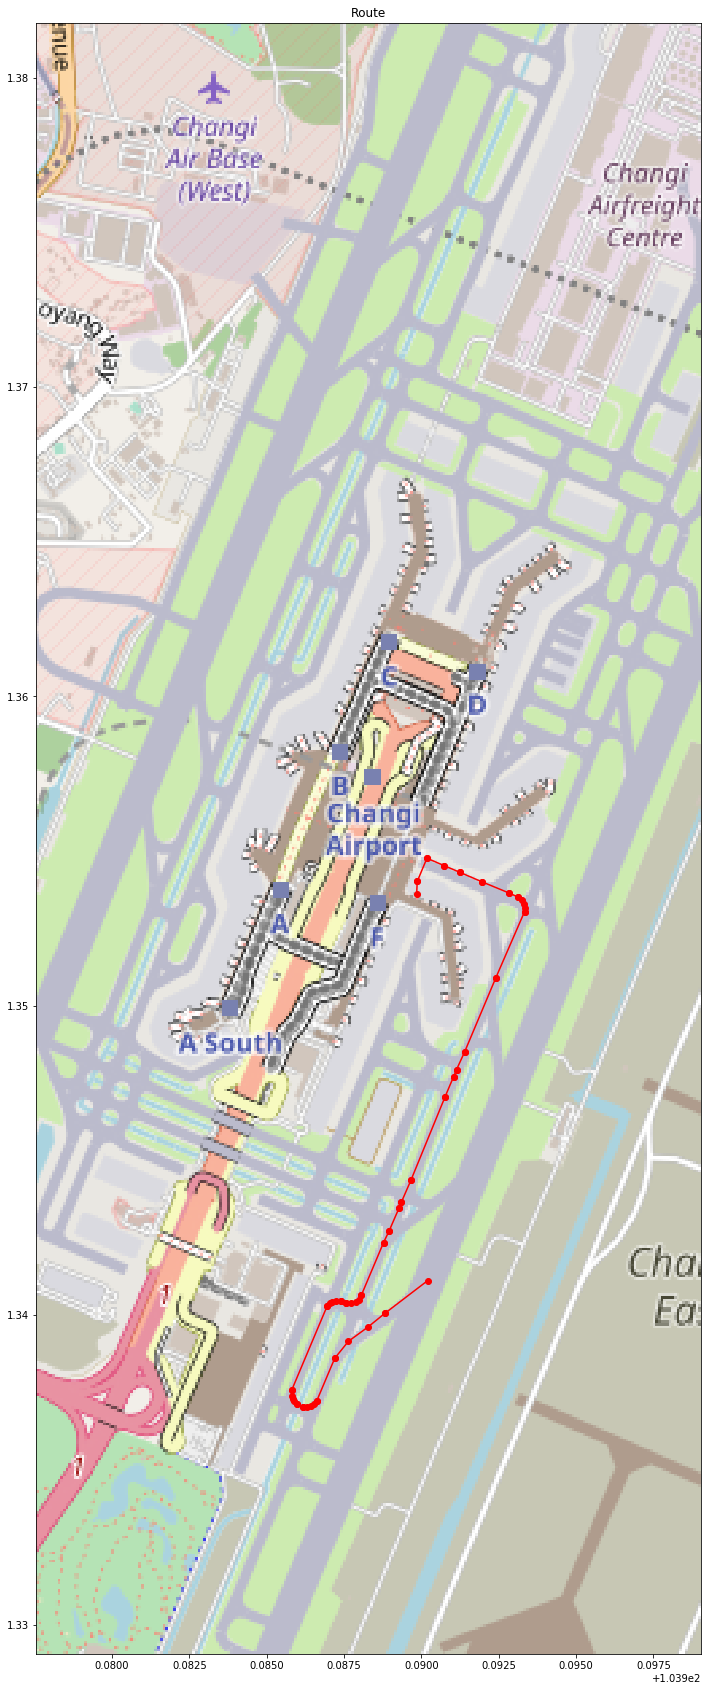

In [36]:
# TEST
# plot route on map if a route is found
image_map = plt.imread(MAP_IMAGE_PATH)
fig, ax = plt.subplots(figsize=(30, 30))
      
way_lon, way_lat =  [], []
for idx, link in enumerate(route):
    members = way_df.loc[link, ['members']].values.tolist()[0]
    if direction[idx]:
        for node_id in reversed(members):
            node = node_df.loc[node_id, ['lat', 'lon']]
            way_lon.append(node.lon)
            way_lat.append(node.lat) 
    else:
        for node_id in members:
            node = node_df.loc[node_id, ['lat', 'lon']]
            way_lon.append(node.lon)
            way_lat.append(node.lat)

plt.plot(way_lon, way_lat,  marker='o',color='r',linestyle='-')  
            
ax.set_title('Route')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

Note: random walk may not be able to find a path in specified number of steps if the random gate is too far from the runway.

In [39]:
# TEST
# arrival flight
arr_gate = random.choice(gate_list) # choose a random gate
route, direction = random_walk(arr_gate, is_departure=False, steps=50000, allow_cycle=False)

Route found: ['23149925', '-105948', '-103813', '-105884', '-103356', '741695441', '-103364', '-105770', '547383980', '-105774', '-105777', '-105713', '547383992', '173010650', '173010725', '-103906', '142868917', '-105217', '-105220', '173010516', '547383970', '-105371', '547383971', '680655361', '-102130']
Reversed direction: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, True, True, False, True, True, False, True]


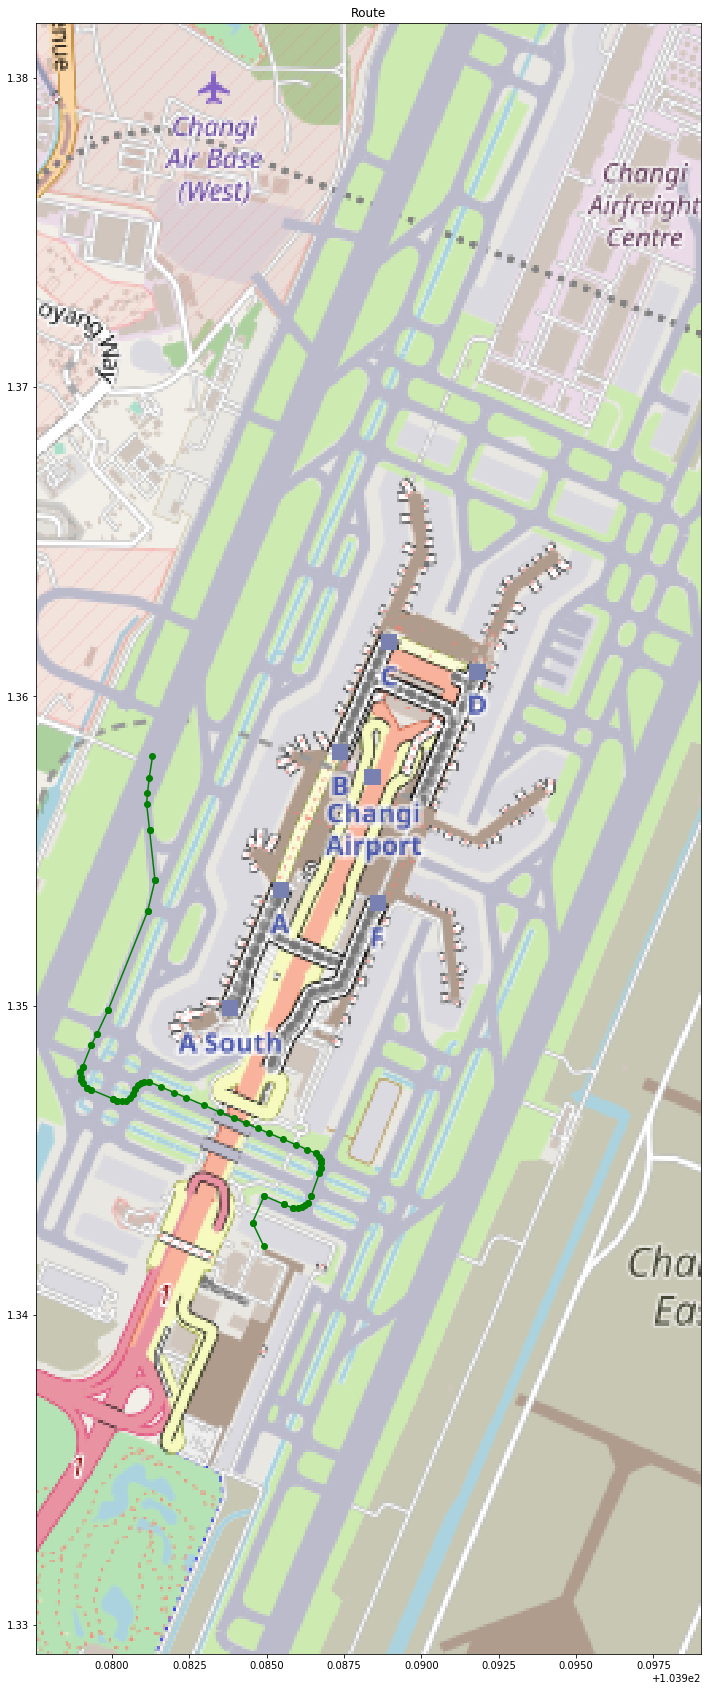

In [40]:
# TEST
# plot route on map if a route is found
image_map = plt.imread(MAP_IMAGE_PATH)
fig, ax = plt.subplots(figsize=(30, 30))
      
way_lon, way_lat =  [], []
for idx, link in enumerate(route):
    members = way_df.loc[link, ['members']].values.tolist()[0]
    if direction[idx]:
        for node_id in reversed(members):
            node = node_df.loc[node_id, ['lat', 'lon']]
            way_lon.append(node.lon)
            way_lat.append(node.lat) 
    else:
        for node_id in members:
            node = node_df.loc[node_id, ['lat', 'lon']]
            way_lon.append(node.lon)
            way_lat.append(node.lat)

plt.plot(way_lon, way_lat,  marker='o',color='green',linestyle='-')  
            
ax.set_title('Route')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

### Construct Node Connectivity Matrix
Use Node Index

In [27]:
NUM_NODES = node_df.shape[0]
C_matrix = [[0 for x in range(NUM_NODES)] for y in range(NUM_NODES)]

for idx in range(NUM_NODES):
    node_id = node_idx2id[idx]
    
    if node_id in node_connectivity.keys():
        for each in node_connectivity[node_id]:
            each_idx = node_id2idx[each]
            C_matrix[idx][each_idx] = 1

### Construct Node Distance Matrix
Use Node Index

In [28]:
node_distance = [[0 for x in range(NUM_NODES)] for y in range(NUM_NODES)]

for idx in range(NUM_NODES):
    node_id = node_idx2id[idx]
    
    if node_id in node_connectivity.keys():
        for each in node_connectivity[node_id]:
            each_idx = node_id2idx[each]
            distance = path_distance(node_id, each)
            node_distance[idx][each_idx] = distance

### Find Shortest Path between 2 Nodes

In [29]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

In [30]:
graph = csr_matrix(node_distance)

In [31]:
dist_matrix, predecessors = shortest_path(
    csgraph=graph, 
    method='D', # use Dijkstra’s algorithm 
    directed=True, # directed
    return_predecessors=True
)

The N x N matrix of distances between graph nodes. dist_matrix[i,j] gives the shortest distance from point i to point j along the graph.

In [32]:
dist_matrix[0]

array([   0.        , 1958.93913537, 1794.29004938, ..., 2490.47636571,
       2485.07560892, 2148.21617193])

The N x N matrix of predecessors, which can be used to reconstruct the shortest paths. Row i of the predecessor matrix contains information on the shortest paths from point i: each entry predecessors[i, j] gives the index of the previous node in the path from point i to point j. If no path exists between point i and j, then predecessors[i, j] = -9999

In [33]:
predecessors[0]

array([-9999,  1398,  1399, ...,  1122,   494,  1362])

In [34]:
# reconstruct shortest path using predecessor matrix
def construct_shortest_path(pr, start, end):
    path = [end]
    curr = end
    while pr[start, curr] != -9999:
        curr = pr[start, curr]
        path.append(curr)
    path.append(start)
    return path[::-1]

Note that shortest path is much faster than random walk and gurantees a route. However, this does not check sharp turn constraint yet.

In [35]:
# TEST
# departure flight
dep_gate = random.choice(gate_list) # choose a random gate
gate_node_id = gate_ref2id[dep_gate]
gate_node_idx = node_id2idx[gate_node_id]

dep_run_id = random.choice(dep_runway) # choose a random node on departure runway
dep_run_idx = node_id2idx[dep_run_id]

route = construct_shortest_path(predecessors, gate_node_idx, dep_run_idx)
print("Shorest Path from", gate_node_idx, "to", dep_run_idx, ":", route)

Shorest Path from 924 to 160 : [924, 924, 1261, 1262, 240, 1257, 1258, 628, 239, 620, 307, 130, 131, 132, 601, 133, 134, 1024, 1025, 231, 1038, 224, 227, 199, 233, 198, 178, 390, 387, 371, 177, 172, 176, 173, 351, 343, 161, 1082, 16, 1014, 168, 154, 155, 341, 156, 157, 1401, 158, 159, 340, 160]


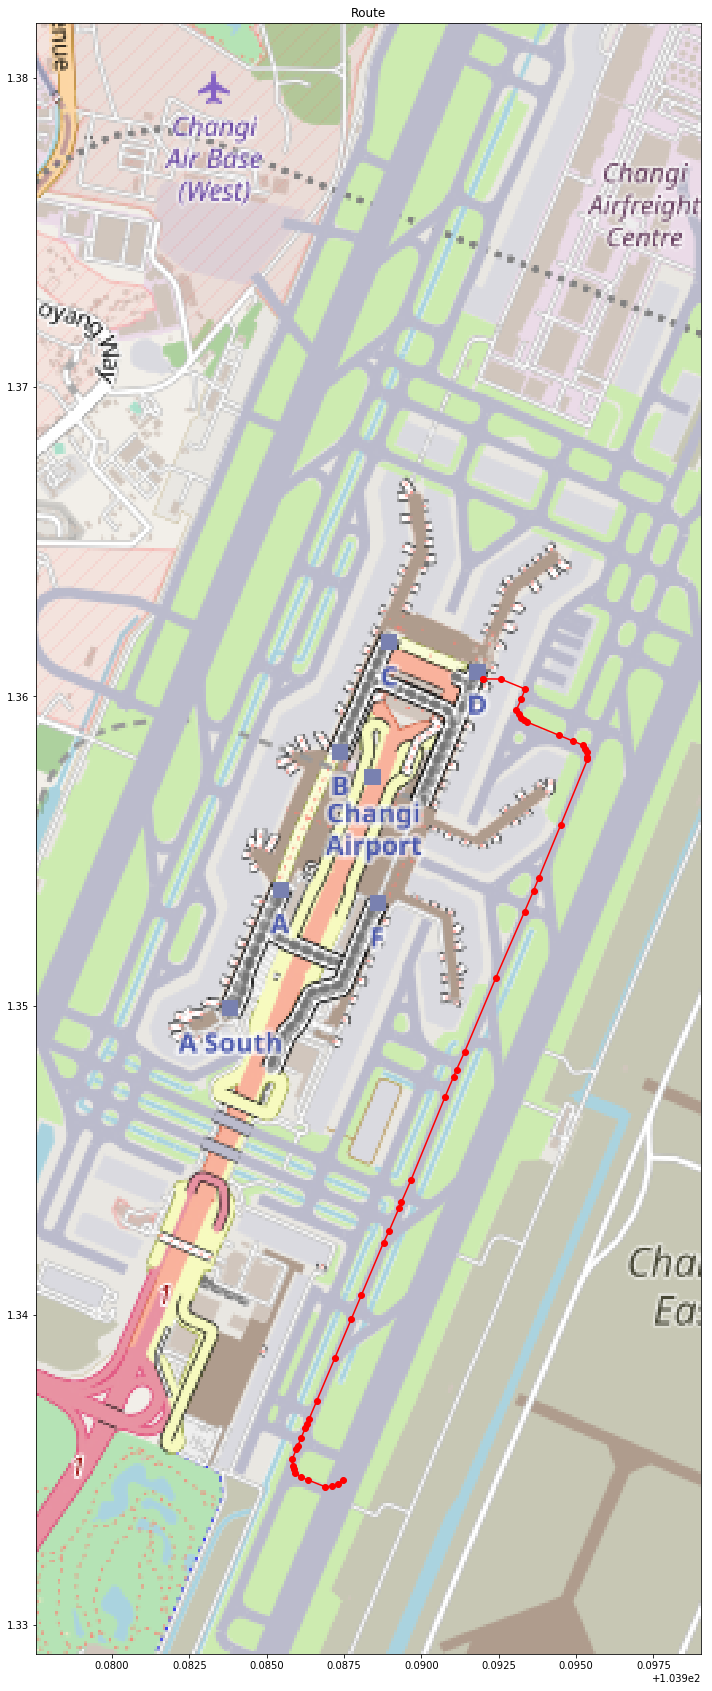

In [36]:
# TEST
# plot route on map
image_map = plt.imread(MAP_IMAGE_PATH)
fig, ax = plt.subplots(figsize=(30, 30))
      
way_lon, way_lat =  [], []
for node_idx in route:
    node_id = node_idx2id[node_idx]
    node = node_df.loc[node_id, ['lat', 'lon']]
    way_lon.append(node.lon)
    way_lat.append(node.lat) 

plt.plot(way_lon, way_lat,  marker='o',color='red',linestyle='-')  
            
ax.set_title('Route')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

Note that shortest path is much faster than random walk and gurantees a route. However, this does not check sharp turn constraint yet.

In [37]:
# TEST
# arrival flight
arr_gate = random.choice(gate_list) # choose a random gate
gate_node_id = gate_ref2id[arr_gate]
gate_node_idx = node_id2idx[gate_node_id]

arr_run_id = random.choice(arr_runway) # choose a random node on arr runway
arr_run_idx = node_id2idx[arr_run_id]

route = construct_shortest_path(predecessors, arr_run_idx, gate_node_idx)
print("Shorest Path from", arr_run_idx, "to", gate_node_idx, ":", route)

Shorest Path from 47 to 901 : [47, 47, 314, 596, 1445, 595, 317, 1172, 62, 1173, 63, 57, 58, 986, 59, 60, 61, 569, 561, 1329, 539, 527, 515, 510, 508, 505, 45, 499, 491, 487, 481, 474, 469, 464, 461, 458, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 323, 321, 327, 324, 192, 1010, 193, 489, 194, 212, 213, 214, 215, 183, 220, 493, 221, 201, 225, 226, 227, 224, 1372, 1374, 1224, 574, 1035, 1034, 587, 1021, 1022, 1023, 1229, 1232, 1235, 1233, 901]


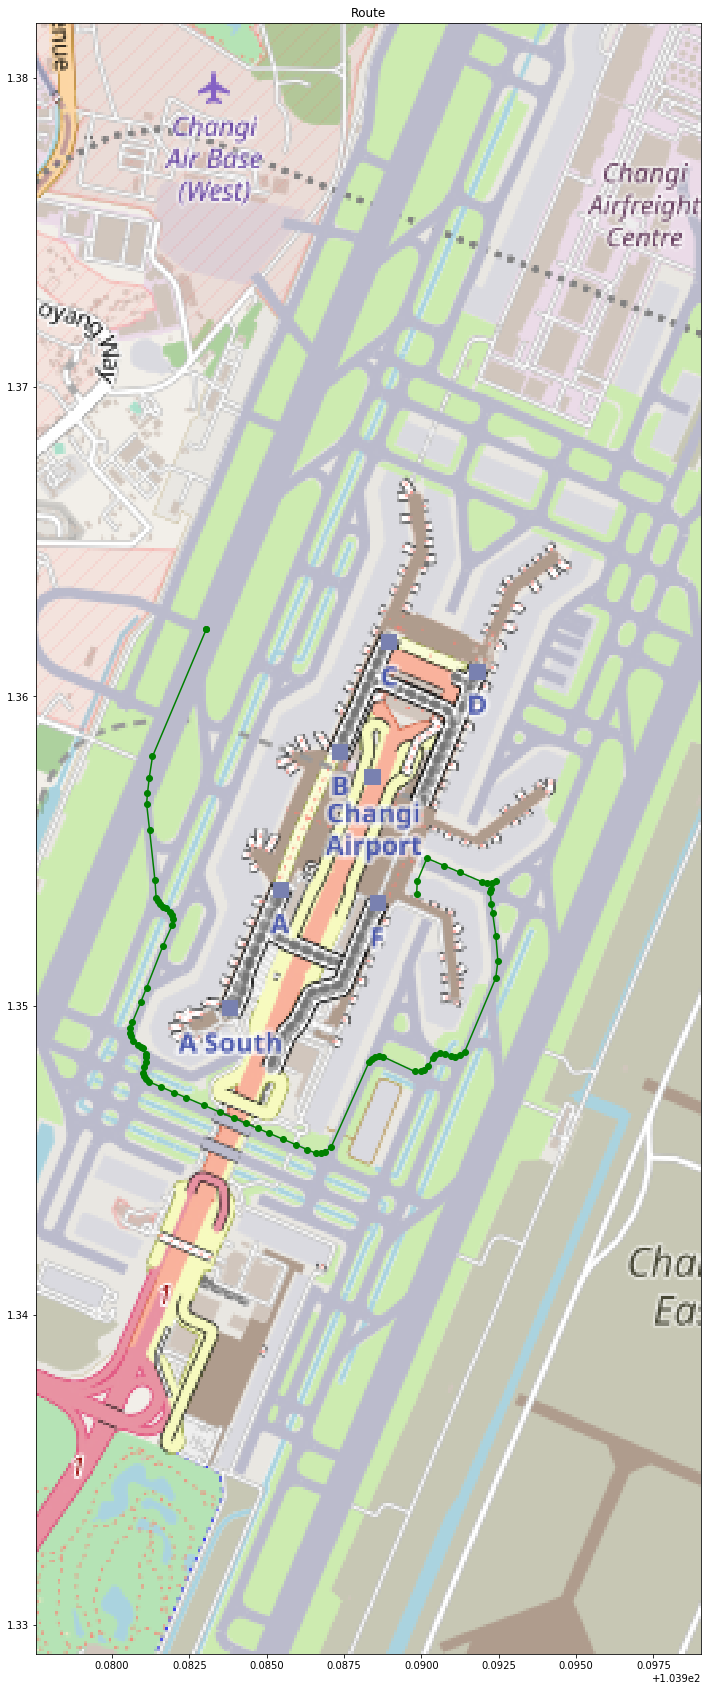

In [38]:
# TEST
# plot route on map
image_map = plt.imread(MAP_IMAGE_PATH)
fig, ax = plt.subplots(figsize=(30, 30))
      
way_lon, way_lat =  [], []
for node_idx in route:
    node_id = node_idx2id[node_idx]
    node = node_df.loc[node_id, ['lat', 'lon']]
    way_lon.append(node.lon)
    way_lat.append(node.lat) 

plt.plot(way_lon, way_lat,  marker='o',color='green',linestyle='-')  
            
ax.set_title('Route')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

### Taxiing time

In [39]:
# the actual route might not always follow the shortest path due to constraints
# the unit of speed is m/s
def calculate_taxi_time(route, speed=5):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += node_distance[route[i]][route[i+1]]
    time = total_distance/speed
    print("Total distance of the route: " + "{:.0f}".format(total_distance) + " meters")
    print("Taxiing speed:", speed, "m/s")
    print("Total time elapsed: " + "{:.0f}".format(time) + " seconds")
    return time

In [40]:
time_elapsed = calculate_taxi_time(route)

Total distance of the route: 4246 meters
Taxiing speed: 5 m/s
Total time elapsed: 849 seconds


# Part 2: Flight Data Processing
- "FlightData.csv" was crawled from open source flight data website and contains all departure flight info on 3 Dec 2019 at Changi Airport
- Extract scheduled departure time and assigned departure gate for each departure flight

In [41]:
# load one day worth of departure flight data
FLIGHT_DATA_PATH = "FlightData.csv"

flight_raw_df = pd.read_csv(FLIGHT_DATA_PATH, usecols=["Flight", "STD", "Gate"])

# filter out flights whose gates are not in the list
flight_df = flight_raw_df[flight_raw_df.Gate.isin(gate_list)]

In [42]:
flight_df.head(5)

Flight           STD Gate
0  SQ362 SIA362  00:00 UTC+08  A15
1  LX177 SWR177  00:01 UTC+08   E7
2        SQ388   00:02 UTC+08   C1
3  IX687 AXB687  00:10 UTC+08   E6
4  SQ225 SIA225  00:10 UTC+08   B7

In [43]:
NUM_AIRCRAFT = flight_df.shape[0]
print("Number of departure aircraft in a day:", NUM_AIRCRAFT)

Number of departure aircraft in a day: 496


In [44]:
# get the start node of departure aircraft 
dep_start_node = []
# get the scheduled departure time in seconds (from 00:00)
scheduled_departure_time = []

for index, row in flight_df.iterrows():
    gate = row["Gate"]
    node_id = gate_ref2id[gate]
    dep_start_node.append(node_id2idx[node_id])  
    
    s = row["STD"]
    time_sec = (int(s[:2]) * 60 + int(s[3:5])) * 60
    scheduled_departure_time.append(time_sec)

In [45]:
# TEST
# scheduled departure time (in seconds) for the first 5 flights
scheduled_departure_time[:5]

[0, 60, 120, 600, 600]

# Part 3: MILP Implementation
This part contains:
1. Update Active Aircraft at the start of each planning horizon
2. Optimize Model based on Constraints and return solution
3. Execute and commit part of the solution and update aircraft status
4. Visualise planned and executed routes on the map
5. Slide window and repeat step 1 to 4

In [46]:
from docplex.mp.model import Model
import time
from bisect import bisect_right

### Helper Functions

In [47]:
def find_gt(a, x):
    'Find smallest value greater than x and return the index'
    i = bisect_right(a, x)
    print("Planned time:", a)
    print("End time of current horizon: {0:0.2f} seconds".format(x))
    if i != len(a):
        return i
    raise ValueError 

In [48]:
# calculate distance between two points given lon and lat
def cal_distance(node_1, node_2): 
    if node_1 in node_idx2id.keys():
        node_1_id = node_idx2id[node_1]
        start_node = node_df.loc[node_1_id, ['lat', 'lon']]
        lat1, lon1 = start_node.lat, start_node.lon     
    else: # if it's a virtual node
        lon1, lat1 = v_coord[node_1]
        
    if node_2 in node_idx2id.keys():
        node_2_id = node_idx2id[node_2]      
        end_node = node_df.loc[node_2_id, ['lat', 'lon']]
        lat2, lon2 = end_node.lat, end_node.lon     
    else: # if it's a virtual node
        lon2, lat2 = v_coord[node_2]     
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result in meters 
    return(c * r) * 1000

In [49]:
def cal_turn_angle(node_1, node_2, node_3):  
    # calculate three sides of the triangle
    a = cal_distance(node_1, node_2)
    b = cal_distance(node_2, node_3)
    c = cal_distance(node_1, node_3)
    
    # approximate the angle using law of cosine
    rad = acos((a*a + b*b - c*c)/(2*a*b))
    angle = rad * 180 /pi
    return angle

In [50]:
def turn_allowed(prev_node, node, next_node):
    if (prev_node, node, next_node) in turn:
        return turn[(prev_node, node, next_node)]
    
    if cal_turn_angle(prev_node, node, next_node) >= 70:
        return 1
    else:
        return 0

In [51]:
def calculate_virtual_node_lonlat(node_1, node_2, L, distance_node2, v_coord):
    print("\t\tCalculating virtual node coordiantes...")
    if node_1 in node_idx2id.keys():
        node_1_id = node_idx2id[node_1]
        start_node = node_df.loc[node_1_id, ['lat', 'lon']]
        lat1, lon1 = start_node.lat, start_node.lon     
    else: # if it's a virtual node
        lon1, lat1 = v_coord[node_1]
        
    if node_2 in node_idx2id.keys():
        node_2_id = node_idx2id[node_2]      
        end_node = node_df.loc[node_2_id, ['lat', 'lon']]
        lat2, lon2 = end_node.lat, end_node.lon     
    else: # if it's a virtual node
        lon2, lat2 = v_coord[node_2]
    
    print("\t\t\tPrevious node: (", lon1, lat1, ")")
    print("\t\t\tNext node: (", lon2, lat2, ")")
    print("\t\t\tDistance between them:", L[node_1][node_2])
    
    v_lat = lat2 + (lat1-lat2)*(distance_node2/L[node_1][node_2])
    v_lon = lon2 + (lon1-lon2)*(distance_node2/L[node_1][node_2])
    return v_lon, v_lat

### Optimizer Functions

In [52]:
# aircraft are considered to be 'active' if they are already taxxing 
# or their scheduled depature time is within in the current window 
def update_active_aircraft(window_start, WINDOW_SIZE, A, scheduled_departure_time, aircraft_route, DEP_R):
    # get new active aircraft whose scheduled departure time fall within the current window
    for a, dep_time in enumerate(scheduled_departure_time):   
        if a not in A and dep_time >= window_start and dep_time <= window_start + WINDOW_SIZE:
            print("Adding aircraft", a, "with scheduled departure time", dep_time, "to the active list")
            A.append(a)
            aircraft_route[a] = []
    
    # exclude aircraft that already reacheh their destination
    to_del = []
    for a in aircraft_route.keys():
        route = aircraft_route[a]
        if DEP_R in route and a in A: 
            print("Removing aircraft", a,  "from the active list")
            A.remove(a) # remove the aircraft from active list
            to_del.append(a)
        
#         for node in route:
#             if DEP_R in node_conn_idx[node] and a in A:
#                 print("Removing aircraft", a,  "from the active list")
#                 A.remove(a) # remove the aircraft from active list
#                 to_del.append(a)
    
    # delete inactive aircraft from aircraft route
    for key in to_del:
        del aircraft_route[key]
    
    return A, aircraft_route

In [53]:
# simulate two types of uncertainties: flight delay and taxiway availability
def random_event_simulator(iteration, node_conn_idx):
    'simulate flight scheduled departure time uncertainty'
    # to-do
    
    'simulate taxiway unavailability uncertainty'
    # to-do
    # for demo
    if iteration >= 3 and iteration <= 5:
        print("******ALERT******\nTaxiway not available from node 198 to node 178")
        print("*****************")
        if 178 in node_conn_idx[198]:
            node_conn_idx[198].remove(178)
    else:
        if 178 not in node_conn_idx[198]:
            print("******ALERT******\nTaxiway is now available from node 198 to node 178")
            print("*****************")
            node_conn_idx[198].append(178)
    
    return node_conn_idx

In [74]:
def optimize_model(iteration, NUM_OF_MOVES, A, N, K, SE, node_conn_idx, L, d_st, n_0, n_m1, t_0, t_start, V, D_SEP, DEP_R):
    
    'create base model'
    model = Model('base');
    
    
    'decision variables'
    # x(a, n, m, k) = 1 if and only aircraft a is routed from node n to node m during planning period k
    X = [(a, n, m, k) for a in A for n in N for m in node_conn_idx[n] for k in K]
    x = model.binary_var_dict(X, name='x');

    # t(a, k) records the time at which aircraft a passes the node during planning period k
    T = [(a, k) for a in A for k in K]
    t = model.continuous_var_dict(T, name='t');

    # z(a) is the estimated time when aircraft a reaches destination
    z = model.continuous_var_dict(A, name='z');
    
    ## auxiliary decision variables
    # SE(a, b, n) = 1 both aircraft a (at move k) and b (at move j) are routed into node n at one point 
    # and a is routed into n before b
    G_SE = [(a, b, n, k, j) for (a, b, n) in SE for k in K for j in K] 
    g_se = model.binary_var_dict(G_SE, name='g_se')
    
    
    'add constraints to the model'
    # The first move has to start from its start node 
    model.add_constraints(
        model.sum(x[a, n_0[a], m, 0] for m in node_conn_idx[n_0[a]]) == 1 
        for a in A
    );
    
    # The time at the end of the first move
    model.add_constraints(t_0[a] <= t[a, 0] for a in A);
    
    # Continuity: if an aircraft moves to node n in period k-1, it must move from node n in period k
    model.add_constraints(
        model.sum(x[a, n, m, k] for m in node_conn_idx[n]) ==
        model.sum(x[a, m, n, k-1] for m in N if n in node_conn_idx[m])
        for a in A for n in N for k in K if k >= 1
    );
    
    # Each aircraft must have a plan for each period k
    model.add_constraints(
        model.sum(x[a, n, m, k] for n in N for m in node_conn_idx[n]) == 1 
        for a in A for k in K
    );
    
    # repeats of the destination node are allowed if required to fill the planning periods
    # the associated times are constrained to be the same
    model.add_constraints(
        t[a, NUM_OF_MOVES-1] <= t[a, k] + 100000 * (1 - model.sum(x[a, n, DEP_R, k-1] for n in N if DEP_R in node_conn_idx[n]))
        for a in A for k in K if k >= 1 and k < NUM_OF_MOVES-1
    );
        
    # route n - m - n is not permitted as it is assumed that aircraft can only travel forwards
    model.add_constraints(
        model.sum(x[a, n, m, k] for k in K) + model.sum(x[a, m, n, k] for k in K) <= 1
        for a in A for n in N for m in node_conn_idx[n] if n in node_conn_idx[m] and n != m
    );
    
    # except for the initial horizon
    if iteration != 0:
        # n - m - n violation has to be checked between horizons
        model.add_constraints(x[a, n_0[a], n_m1[a], 0] == 0 
            for a in A if a in n_m1.keys() and n_m1[a] in node_conn_idx[n_0[a]]
        );
        
    # turn angle
#     model.add_constraints(x[a, n, m, k] + x[a, m, p, k+1] <= 1 + 100000 * turn_allowed(n, m, p)
#         for a in A for n in N for m in node_conn_idx[n] for p in node_conn_idx[m] if p!=n for k in K if k < NUM_OF_MOVES-1 
#     );

        
    # speed limit. L is the node distance matrix
    model.add_constraints(
        t[a, k] + model.sum(x[a, n, m, k]*L[n][m] for n in N for m in node_conn_idx[n] if m < len(L[n]))/V <= t[a, k+1]
        for a in A for k in K if k < NUM_OF_MOVES-1
    );
    
    # destination time
    model.add_constraints(
        z[a] == t[a, NUM_OF_MOVES-1] + 
        model.sum(x[a, n, m, NUM_OF_MOVES-2]*d_st[m][DEP_R] for n in N for m in node_conn_idx[n] if m < len(d_st))/V
        for a in A
    );
    
    'auxiliary decision variable contraints'
    model.add_constraints(
        g_se[a, b, m, k, j] >= model.sum(x[a, n, m, k] for n in N if m in node_conn_idx[n]) +
            model.sum(x[b, n, m, j] for n in N if m in node_conn_idx[n]) - 1
        for (a, b, m, k, j) in G_SE
    )
    
    model.add_constraints(
        g_se[a, b, m, k, j] <= model.sum(x[a, n, m, k] for n in N if m in node_conn_idx[n])
        for (a, b, m, k, j) in G_SE
    )
    
    model.add_constraints(
        g_se[a, b, m, k, j] <= model.sum(x[b, n, m, j] for n in N if m in node_conn_idx[n])
        for (a, b, m, k, j) in G_SE
    )
    
    # temporal separation at node
    model.add_indicator_constraints(
        model.indicator_constraint(g_se[a, b, m, k, j], 
                                   t[b, k] >= t[a, j] + D_SEP/V)
        for (a, b, m, k , j) in G_SE
    )
    
    
    'add objective function'
    # minimize total taxiing time and total distance travelled 
    model.minimize(
        5 * model.sum(z[a]-t_start[a] for a in A) +
        3* model.sum(
            L[n][m] * x[a, n, m, k] + 
            2*d_st[m][DEP_R] * x[a, n, m, k] 
            for a in A for n in N for m in node_conn_idx[n] if m < len(d_st) for k in K
        )
    )
    
    'solve model'
    model.parameters.mip.tolerances.mipgap = 0.1;
    solution = model.solve(log_output = False)
    # print(solution)
    
    return solution

In [80]:
# execute partial solution
def execute_sol(solution, curr_horizon_start, A, aircraft_route, n_0, n_m1, t_0,
                K, N, node_conn_idx, L, v_coord, V, DEP_R):
         
    time_at_move = {a: [0 for k in K] for a in A} # estimated time at end of period k
    planned_route = {a: [-1 for k in range(NUM_OF_MOVES + 1)] for a in A} # planned route over current planning periods
    v_a = {a: -2 for a in A} # virtual node for aircraft a
    time_at_node = {}
    min_horizon = 999999
    
    # read solution
    sol= str(solution).strip().split('\n')
    for line in sol:
        if line[0] == 't': # time at the end of each step
            line_split = line.split('=')
            a, k = map(int, line_split[0][2:].split('_'))
            time_at_move[a][k] = float(line_split[1])                            
           
    # get the length of the current execution horzion
    # since each aircraft is not necessarily synchorized, we need to use the minimal time length as the execution horizon
    for a in time_at_move.keys():
        min_horizon = min(time_at_move[a][-1]-curr_horizon_start, min_horizon)
    
    print("Current Execution Horizon Length (in seconds):", min_horizon)
    
    # execute until horizon end
    curr_horizon_end = curr_horizon_start + min_horizon
    print("Executing solutions from ", curr_horizon_start, "to", curr_horizon_end)
    
    # find out the aircraft a is in the middle of which move at end of the execution horizon
    k_end = {a: -1 for a in A}
    for a in time_at_move.keys():
        print("\nFinding terminal position at the end of current horizon for aircraft", a)
        # if the aircraft can be scheduled to start taxiing in the current horizon
#         if time_at_move[a][0] <= curr_horizon_end: 
        if time_at_move[a][-1] == curr_horizon_end:          
            k_end[a] = len(time_at_move[a])
            print("Planned:", time_at_move[a])
            print("Aircraft", a, "is right at the end of all planned moves")
        elif time_at_move[a][0] >= curr_horizon_end:
            k_end[a] = -1
            print("Planned:", time_at_move[a])
            print("Aircraft", a, "is not scheduled to start taxiing yet.")
        else:
            try:
                k_end[a] = find_gt(time_at_move[a], curr_horizon_end)
                print("Aircraft", a, "is in the middle of move",  k_end[a])
            except ValueError as e:
                print("All planned nodes will be executed by the end of current horizon")
            
        
    for line in sol:       
        if line[0] == 'x': # routing at each step   
            a, n, m, k = map(int, line[2:-2].split('_'))
            # print("Planned: Aircraft {0} is routed from node {1} to node {2} in period {3}".format(a, n, m, k))
            if k == 0:
                planned_route[a][0] = n
                planned_route[a][1] = m
            else:
                planned_route[a][k+1] = m
            
            if k == k_end[a]-1:
                if k_end[a] != len(time_at_move[a]):
                    # the aircraft is taxxing from n to m at the end of execution horizon
                    # create a virtual node for aircraft a between n and m
                    # create virtual index        
                    v_idx = len(N)
                    v_a[a] = v_idx

                    # append the virtual node in the all node set
                    N.append(v_idx) 
                    print("\nCreating a new virtual node", v_idx, "for aircraft", a)

                    print("\tCurret number of nodes", len(N))

                    # add it to the connectivity and distance matrix
                    new_connedted = [m]
                    print("\tVirtual node is only connected to:", m)
                    node_conn_idx[v_idx] = new_connedted
                    node_conn_idx[m].append(v_idx)

                    # distance between v_a and all other nodes
                    new_distance = [99999 for n in N]   
                    # calculate the distance between m and v_a
                    dist_2_n = V * (curr_horizon_end - time_at_move[a][k])
                    print("\tDistance from the previous node to virtual node: {0:0.2f}m".format(dist_2_n))
                    dist_2_m = L[n][m] - dist_2_n
                    new_distance[m] = dist_2_m
                    L[v_idx] = new_distance
                    print("\tDistance from the virtual node to the next node: {0:0.2f}m".format(dist_2_m))

                    # calculate the lat and lon of the virtual node
                    lon, lat = calculate_virtual_node_lonlat(n, m, L, dist_2_m, v_coord)
                    print("Virtual Node Coordinate: (", lon, lat, ")")
                    v_coord[v_idx] = (lon, lat)

                    n_0[a] = v_a[a]  # start node for the next horizon is the terminal node of the current horizon
                    print("\nUpdate aircraft", a, "start node for the next horizon", v_a[a])
                    n_m1[a] = n # the previous node before the terminal node of the current horizon
                    print("Node before virtual node", n)
                else:
                    n_0[a] = m  # start node for the next horizon is the terminal node of the current horizon
                    print("\nUpdate aircraft", a, "start node for the next horizon", m)
                    n_m1[a] = n # the previous node before the terminal node of the current horizon
                    print("Node before virtual node", n)
                       
             
    # execution horizon
    for a in A:
        print("\nAdding executed nodes to the executed route for aircraft", a)
        # if the aircraft can be scheduled to start taxiing in the current horizon
#         if t_0[a] <= curr_horizon_end: 
            # update start time for the next horizon
        if k_end[a] != -1:
            t_0[a] = curr_horizon_end

        for k, node in enumerate(planned_route[a]):  
            if a not in aircraft_route.keys():
                aircraft_route[a] = []

            if k <= k_end[a] - 1:
                print("\tAdding node", node, "to the executed route...")
                if node not in aircraft_route[a]:
                    aircraft_route[a].append(node)
            
            if k_end[a] == len(time_at_move[a]) and k == k_end[a]:
                print("\tAdding node", node, "to the executed route...")
                if node not in aircraft_route[a]:
                    aircraft_route[a].append(node)
                    
            if k >= 1:
                time_at_node[(a, node)] = time_at_move[a][k-1]
            
        if k_end[a] != len(time_at_move[a]) and k_end[a] != -1:
            aircraft_route[a].append(v_a[a])
            
    return curr_horizon_end, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node

In [96]:
def detect_potential_conflicts(planned_route, A, time_at_node):
    SE = []
    # for each active flight pair
    for a, b in itertools.combinations(A, 2):
        # find common nodes in the routes
        a_set = set(planned_route[a])
        b_set = set(planned_route[b])
        if (a_set & b_set): 
            common = a_set & b_set
            for each in common:
                if (a, each) in time_at_node.keys() and (b, each) in time_at_node.keys():
                    move_a = planned_route[a].index(each)
                    move_b = planned_route[a].index(each)
                    if time_at_node[(a, each)] < time_at_node[(b, each)]:
                        SE.append((a, b, each))
                    else:
                        SE.append((b, a, each))
        
    print("Potential conflicts:", SE)
    return SE

In [57]:
def plot_route(aircraft_route, planned_route, A):
    # plot route on map
    image_map = plt.imread(MAP_IMAGE_PATH)
    fig, ax = plt.subplots(figsize=(30, 30))
    colors = ["red", "green", "blue", "yellow", "black", "orange", "grey", "purple", "pink"]

    # shortest path
    # for a in A:
    #     shortest_route = construct_shortest_path(predecessors, dep_start_node[a], 6)
    #     way_lon, way_lat =  [], []
    #     for node_idx in shortest_route:
    #         if node_idx != -1:
    #             node_id = node_idx2id[node_idx]
    #             node = node_df.loc[node_id, ['lat', 'lon']]
    #             way_lon.append(node.lon)
    #             way_lat.append(node.lat) 

    #     plt.plot(way_lon, way_lat,  marker='o',color="purple",linestyle='-')
    
    # planned route
    for a in planned_route.keys():
        if a in A:
            way_lon, way_lat =  [], []
            route = planned_route[a]
            for node_idx in route:
                if node_idx != -1 and node_idx in node_idx2id.keys():
                    node_id = node_idx2id[node_idx]
                    node = node_df.loc[node_id, ['lat', 'lon']]
                    way_lon.append(node.lon)
                    way_lat.append(node.lat) 
                    
                if node_idx != -1 and node_idx in v_coord.keys(): # plot virtual nodes
                    lon, lat = v_coord[node_idx]
                    way_lon.append(lon)
                    way_lat.append(lat)
                    
            plt.plot(way_lon, way_lat,  marker='o',color="red",linestyle='-')  
            
            
    # executed route
    for a in aircraft_route.keys():
        if a in A:
            way_lon, way_lat =  [], []
            route = aircraft_route[a]
            for node_idx in route:
                if node_idx != -1 and node_idx in node_idx2id.keys():
                    node_id = node_idx2id[node_idx]
                    node = node_df.loc[node_id, ['lat', 'lon']]
                    way_lon.append(node.lon)
                    way_lat.append(node.lat) 
                    
                if node_idx != -1 and node_idx in v_coord.keys(): # plot virtual nodes
                    lon, lat = v_coord[node_idx]
                    way_lon.append(lon)
                    way_lat.append(lat)

            plt.plot(way_lon, way_lat,  marker='o',color="green",linestyle='-')  
    
    ax.set_title('Route')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(image_map, zorder=0, extent = BBox, aspect= 'equal')

### Initialization

In [97]:
## initialization
# parameters
NUM_OF_NODES = node_df.shape[0]
NUM_OF_MOVES = 6 # number of planning period in a planning horizon
WINDOW_SIZE = 600 # in seconds
# EXECUTION_HORIZON = 42.3 # in seconds
HORIZON_START = 0 # the start time of the first execution horizon
V = 5 # speed limit in m/s
D_SEP = 30 # minimal separation distance between aircraft (in meters)
DEP_R = 153 # node index for departure runway 153

# rolling window for optimization
curr_horizon_start = HORIZON_START

# define domains
A = [] # initial active aircraft
K = [k for k in range(NUM_OF_MOVES)] # planning periods/moves
N = [n for n in range(NUM_OF_NODES)] # nodes
SE = [] # potential conflict at between two aircraft at a node


# for the first execution horizon, start nodes of each aircraft
n_0 = {a:dep_start_node[a] for a in range(len(dep_start_node))}
# the node before terminal node of the previous horizon
n_m1 = {}
# taxi start time for aircraft a
t_0 = {a:scheduled_departure_time[a] for a in range(len(scheduled_departure_time))}
t_start = t_0

# executed route for active aircraft in the current horizon
aircraft_route = {}

iteration = 0

# virtual nodes for aircraft a
v_a = {}
# coordiantes of virtual nodes
v_coord = {}

In [98]:
# node connectivity list using index (for MILP implementation)
node_conn_idx = {}
for idx in node_idx2id.keys():
    id_ = node_idx2id[idx]
    connected_nodes = [] 
    if id_ in node_connectivity.keys():
        for node_id in node_connectivity[id_]:
            connected_nodes.append(node_id2idx[node_id])
    # remove duplicates
    connected_nodes = list(set(connected_nodes)) 
    node_conn_idx[idx] = connected_nodes
    
# convert matrix to dictionary for MILP implementation
L = {x: node_distance[x] for x in range(NUM_NODES)}

dist_matrix[DEP_R][DEP_R] = -10000

## Iterative Optimizer (Step by Step for Illustration)
### Iteration 1

Iteration: 1 starts at 0.00 seconds
Current active aircraft time window: 0.00 to 600.00 seconds
Adding aircraft 0 with scheduled departure time 0 to the active list
Adding aircraft 1 with scheduled departure time 60 to the active list
Adding aircraft 2 with scheduled departure time 120 to the active list
Adding aircraft 3 with scheduled departure time 600 to the active list
Adding aircraft 4 with scheduled departure time 600 to the active list
Adding aircraft 5 with scheduled departure time 600 to the active list
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 53.589
Executing solutions from  0 to 53.589

Finding terminal position at the end of current horizon for aircraft 0
Planned: [0, 20.012, 40.948, 47.825, 50.879, 53.589]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned: [60.0, 70.644, 90.389, 102.226, 143.7, 153.376]
Aircraft 1 is not scheduled to start ta

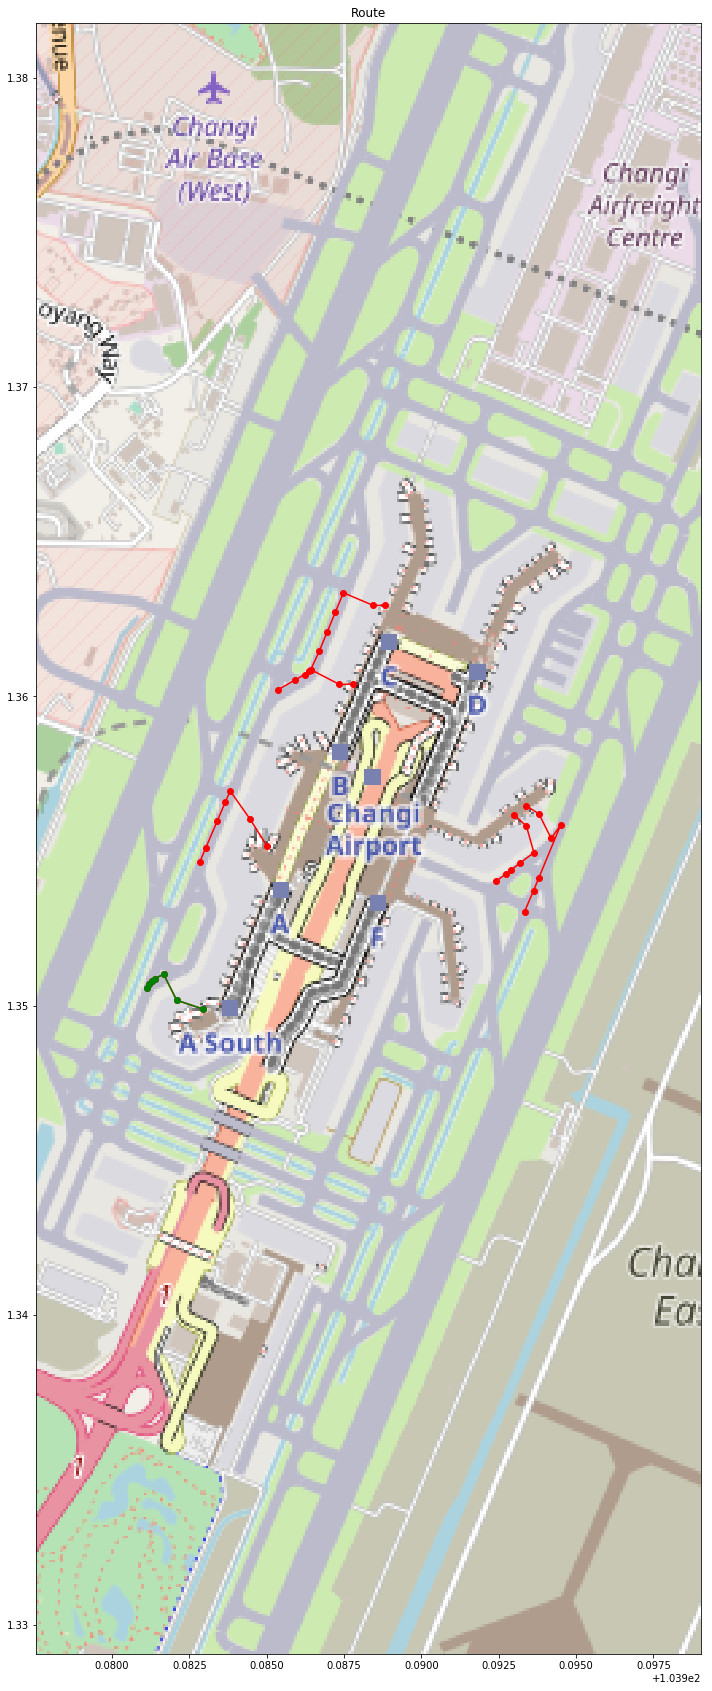

In [99]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 2

Iteration: 2 starts at 53.59 seconds
Current active aircraft time window: 53.59 to 653.59 seconds
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 47.949
Executing solutions from  53.589 to 101.538

Finding terminal position at the end of current horizon for aircraft 0
Planned: [53.589, 65.057, 80.494, 85.187, 97.015, 101.538]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [60.0, 70.644, 90.389, 102.226, 143.7, 153.376]
End time of current horizon: 101.54 seconds
Aircraft 1 is in the middle of move 3

Finding terminal position at the end of current horizon for aircraft 2
Planned: [120.0, 128.684, 151.926, 167.163, 182.078, 197.118]
Aircraft 2 is not scheduled to start taxiing yet.

Finding terminal position at the end of current horizon for aircraft 3
Planned: [600.0, 611.921, 631.595, 644.514, 651.968, 656.622]
Aircraft 3 is not scheduled to start taxiin

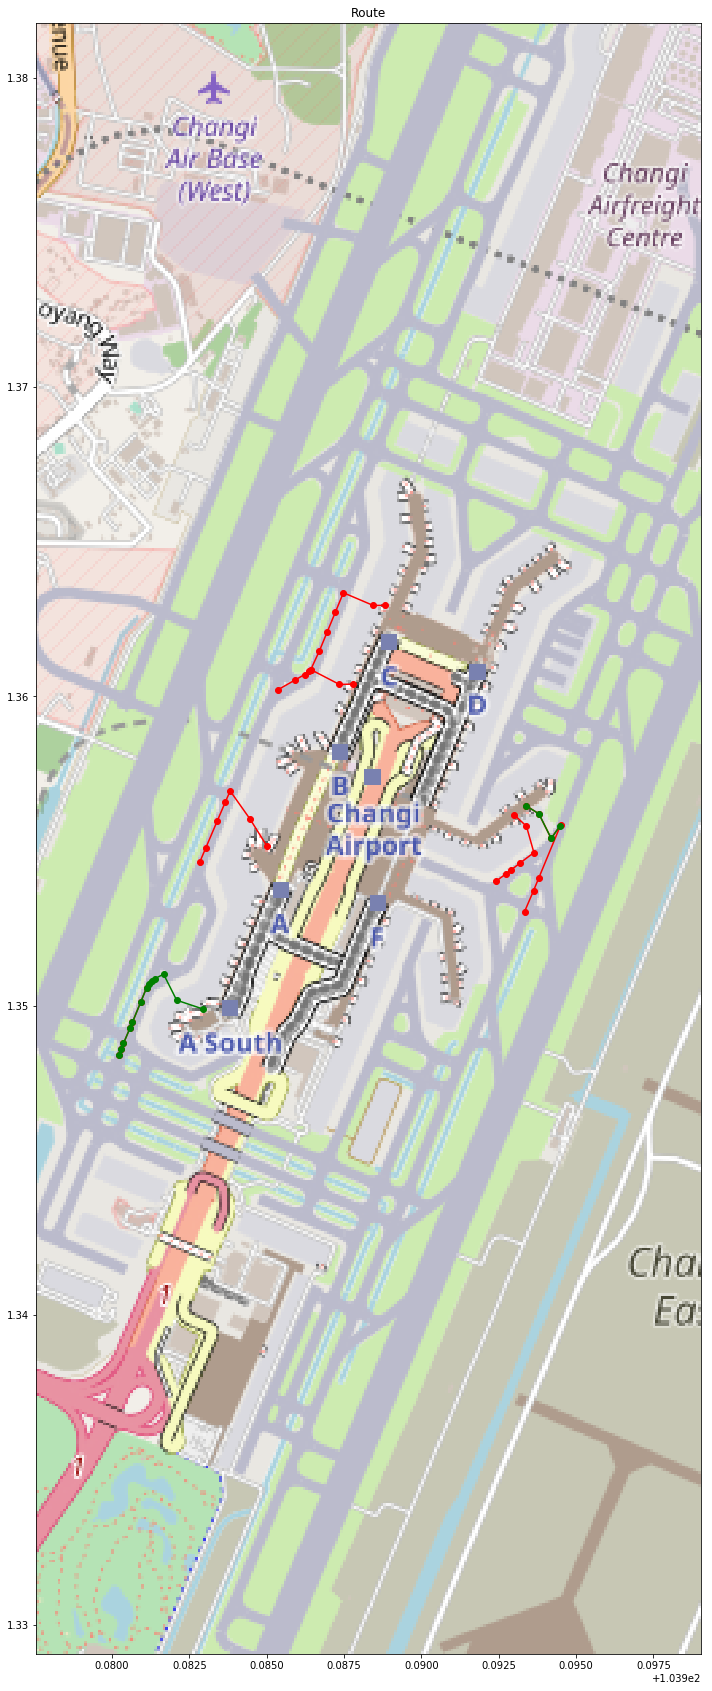

In [100]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 3

Iteration: 3 starts at 101.54 seconds
Current active aircraft time window: 101.54 to 701.54 seconds
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 34.67800000000001
Executing solutions from  101.538 to 136.216

Finding terminal position at the end of current horizon for aircraft 0
Planned: [101.538, 119.543, 124.582, 127.569, 131.638, 136.216]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [101.538, 102.226, 143.699, 153.376, 169.762, 221.648]
End time of current horizon: 136.22 seconds
Aircraft 1 is in the middle of move 2

Finding terminal position at the end of current horizon for aircraft 2
Planned time: [120.0, 128.684, 151.926, 167.163, 182.078, 197.118]
End time of current horizon: 136.22 seconds
Aircraft 2 is in the middle of move 2

Finding terminal position at the end of current horizon for aircraft 3
Planned: [600.0, 611.921, 631.595, 644.514

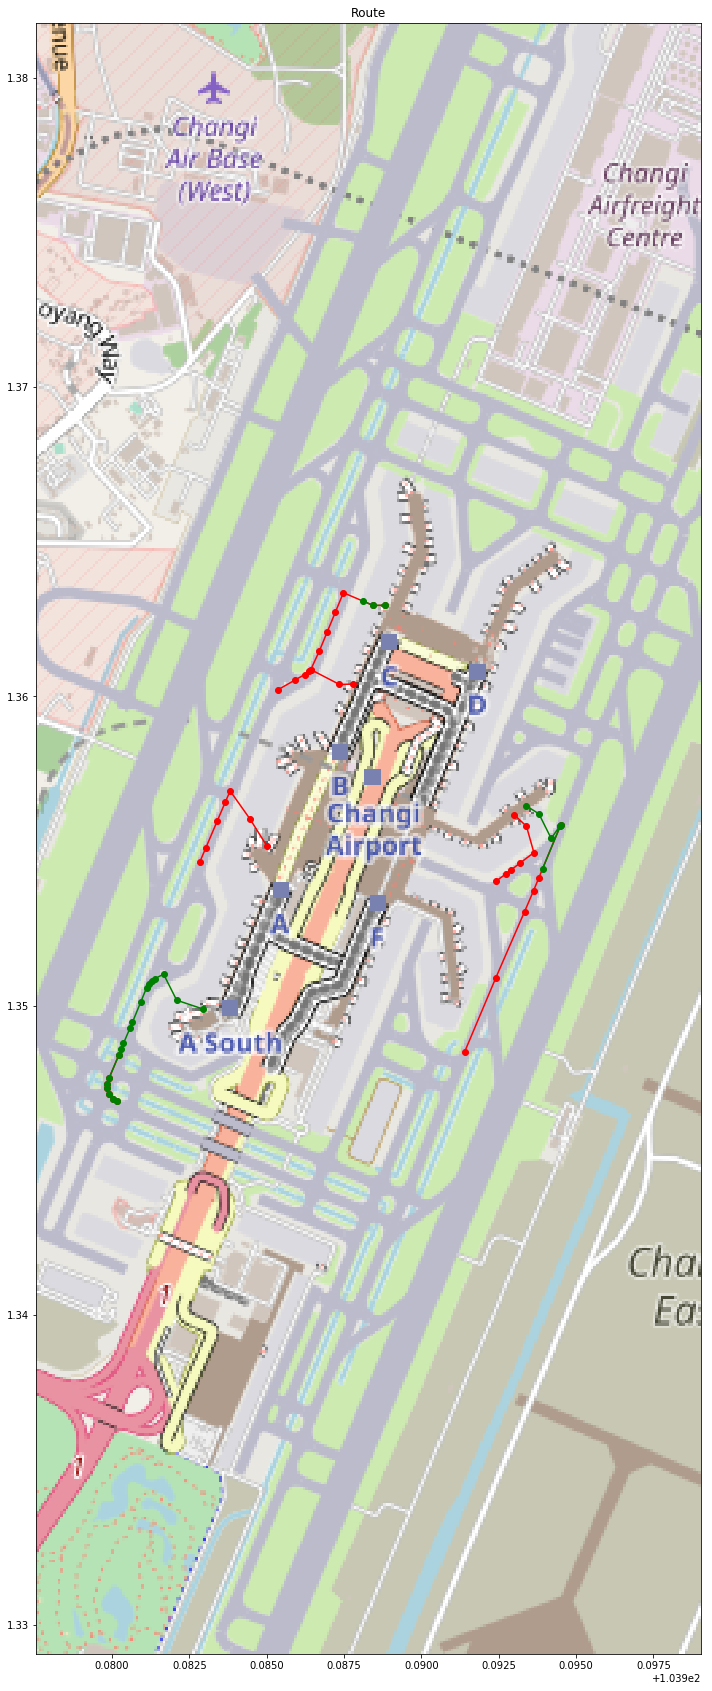

In [101]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 4

Iteration: 4 starts at 136.22 seconds
Current active aircraft time window: 136.22 to 736.22 seconds
******ALERT******
Taxiway not available from node 198 to node 178
*****************
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 43.066
Executing solutions from  136.216 to 179.282

Finding terminal position at the end of current horizon for aircraft 0
Planned: [136.216, 153.186, 159.452, 165.052, 171.438, 179.282]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [136.216, 143.699, 153.376, 169.762, 221.648, 279.036]
End time of current horizon: 179.28 seconds
Aircraft 1 is in the middle of move 4

Finding terminal position at the end of current horizon for aircraft 2
Planned time: [136.216, 151.926, 167.163, 182.078, 197.118, 211.928]
End time of current horizon: 179.28 seconds
Aircraft 2 is in the middle of move 3

Finding terminal position at the end o

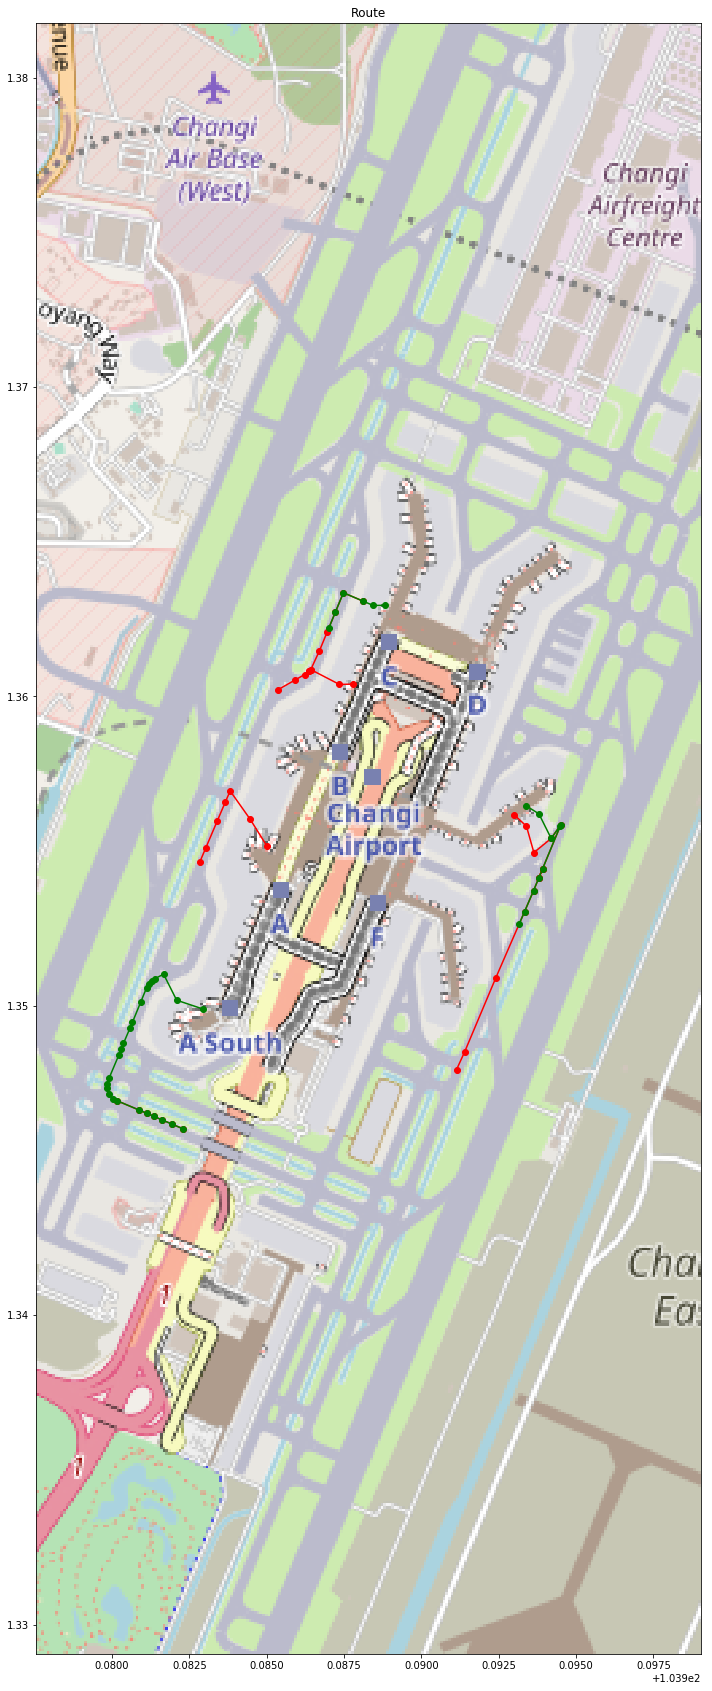

In [102]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 5

Iteration: 5 starts at 179.28 seconds
Current active aircraft time window: 179.28 to 779.28 seconds
******ALERT******
Taxiway not available from node 198 to node 178
*****************
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 38.304
Executing solutions from  179.282 to 217.586

Finding terminal position at the end of current horizon for aircraft 0
Planned time: [179.282, 187.566, 195.942, 204.944, 215.287, 227.204]
End time of current horizon: 217.59 seconds
Aircraft 0 is in the middle of move 5

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [179.282, 221.648, 279.036, 293.393, 298.773, 314.344]
End time of current horizon: 217.59 seconds
Aircraft 1 is in the middle of move 1

Finding terminal position at the end of current horizon for aircraft 2
Planned: [179.282, 182.078, 197.119, 211.928, 213.571, 217.586]
Aircraft 2 is right at the end of all planned moves

Finding terminal position at the end o

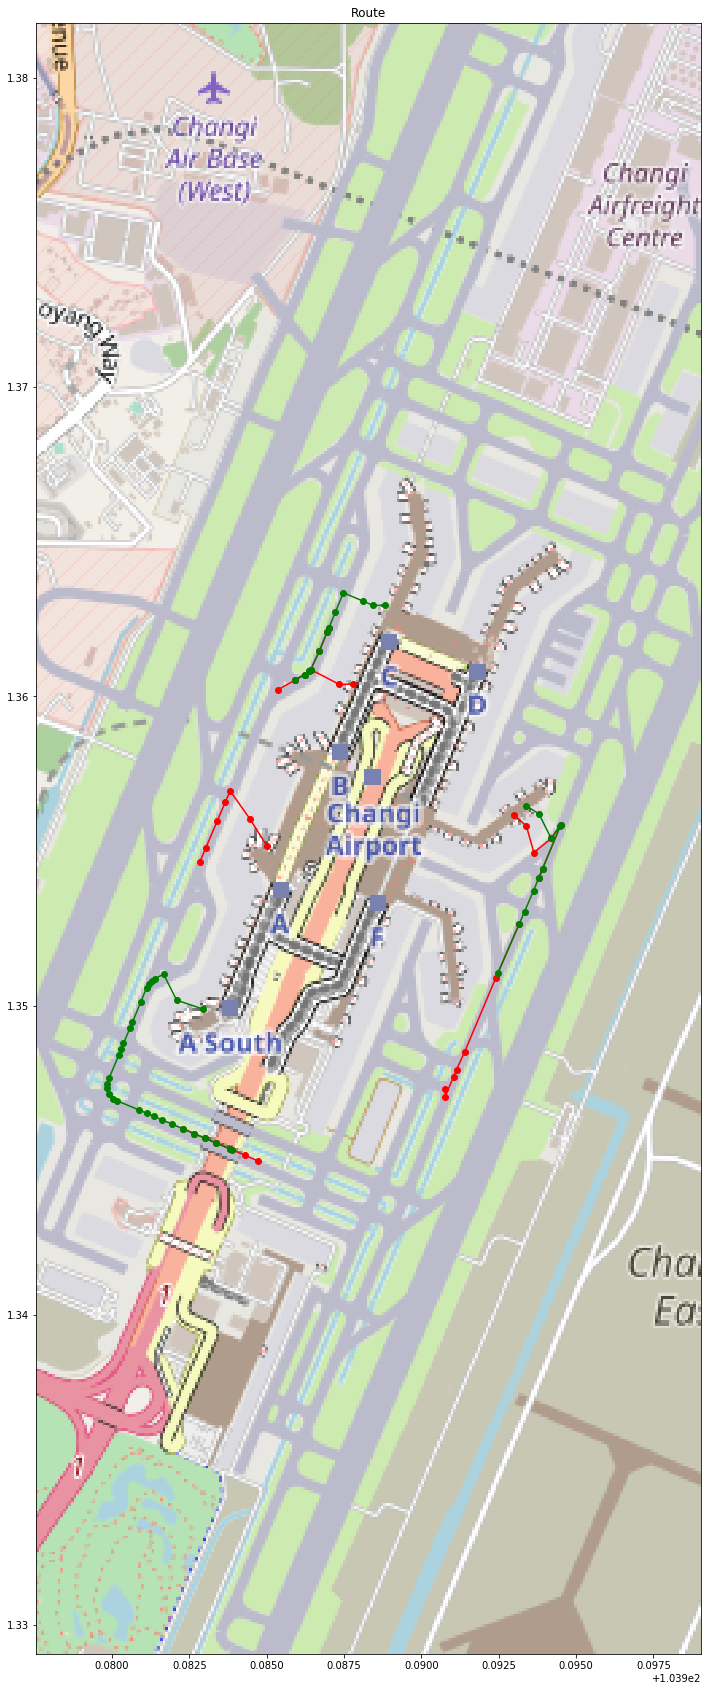

In [103]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 6

Iteration: 6 starts at 217.59 seconds
Current active aircraft time window: 217.59 to 817.59 seconds
******ALERT******
Taxiway not available from node 198 to node 178
*****************
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 49.16300000000001
Executing solutions from  217.586 to 266.749

Finding terminal position at the end of current horizon for aircraft 0
Planned: [217.586, 227.204, 237.871, 248.631, 256.822, 266.749]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [217.586, 221.648, 279.036, 293.393, 298.773, 314.344]
End time of current horizon: 266.75 seconds
Aircraft 1 is in the middle of move 2

Finding terminal position at the end of current horizon for aircraft 2
Planned time: [217.586, 231.49, 242.963, 250.761, 271.542, 294.47]
End time of current horizon: 266.75 seconds
Aircraft 2 is in the middle of move 4

Finding terminal position at 

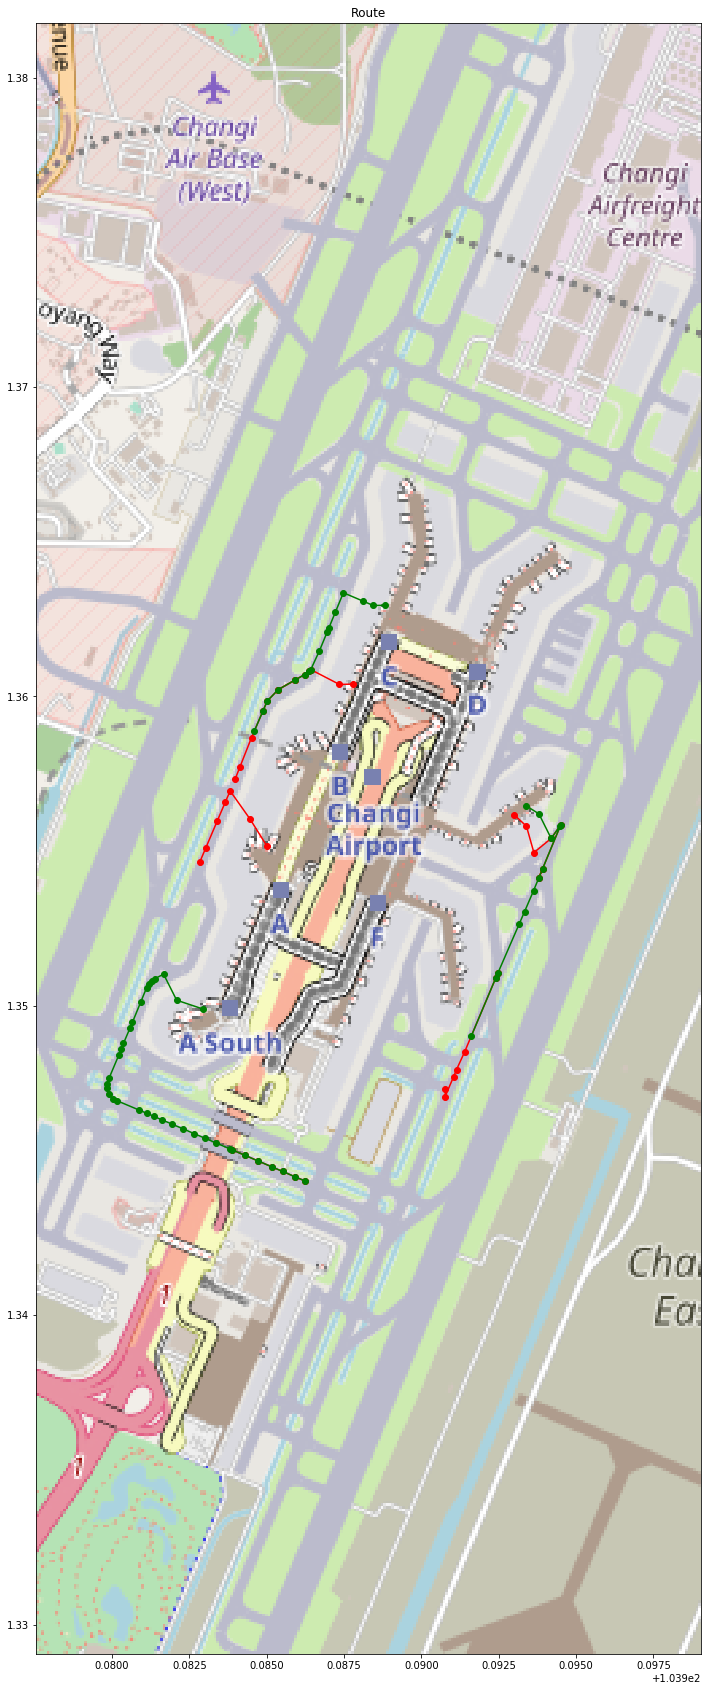

In [104]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 7

Iteration: 7 starts at 266.75 seconds
Current active aircraft time window: 266.75 to 866.75 seconds
******ALERT******
Taxiway is now available from node 198 to node 178
*****************
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 16.017999999999972
Executing solutions from  266.749 to 282.767

Finding terminal position at the end of current horizon for aircraft 0
Planned: [266.749, 270.827, 273.538, 275.855, 278.961, 282.767]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [266.749, 279.036, 293.393, 298.773, 314.344, 378.982]
End time of current horizon: 282.77 seconds
Aircraft 1 is in the middle of move 2

Finding terminal position at the end of current horizon for aircraft 2
Planned time: [266.749, 271.541, 294.47, 303.456, 305.29, 312.925]
End time of current horizon: 282.77 seconds
Aircraft 2 is in the middle of move 2

Finding terminal position

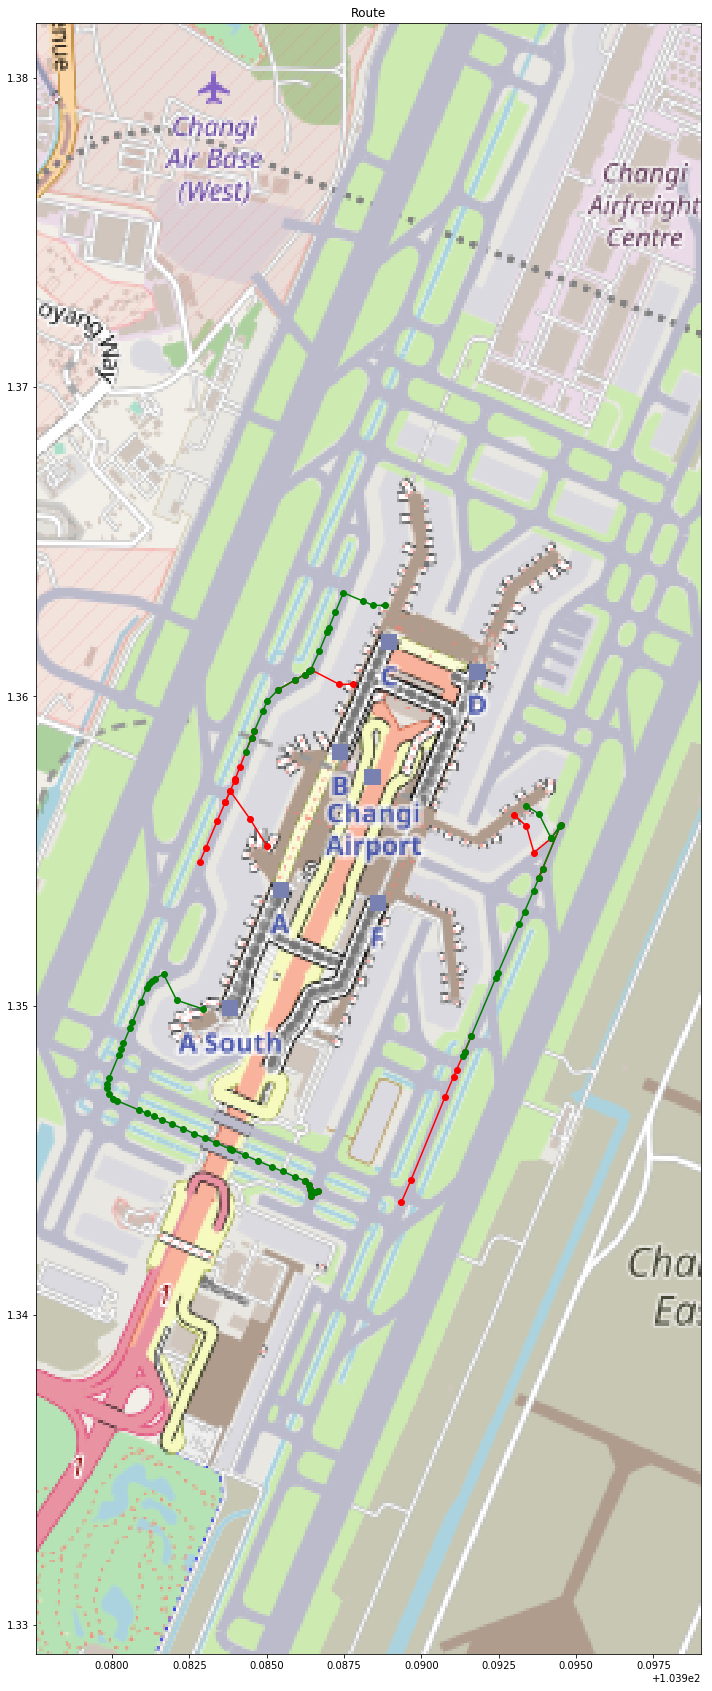

In [105]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 8

Iteration: 8 starts at 282.77 seconds
Current active aircraft time window: 282.77 to 882.77 seconds
Current active aircraft: [0, 1, 2, 3, 4, 5]
Current Execution Horizon Length (in seconds): 39.137
Executing solutions from  282.767 to 321.904

Finding terminal position at the end of current horizon for aircraft 0
Planned time: [282.767, 285.383, 289.16, 311.823, 329.804, 332.149]
End time of current horizon: 321.90 seconds
Aircraft 0 is in the middle of move 4

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [282.767, 293.393, 298.773, 314.344, 378.982, 396.77]
End time of current horizon: 321.90 seconds
Aircraft 1 is in the middle of move 4

Finding terminal position at the end of current horizon for aircraft 2
Planned: [282.767, 294.47, 303.455, 305.29, 312.925, 321.904]
Aircraft 2 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 3
Planned: [600.0, 611.921, 631.595, 647.665, 659.502, 70

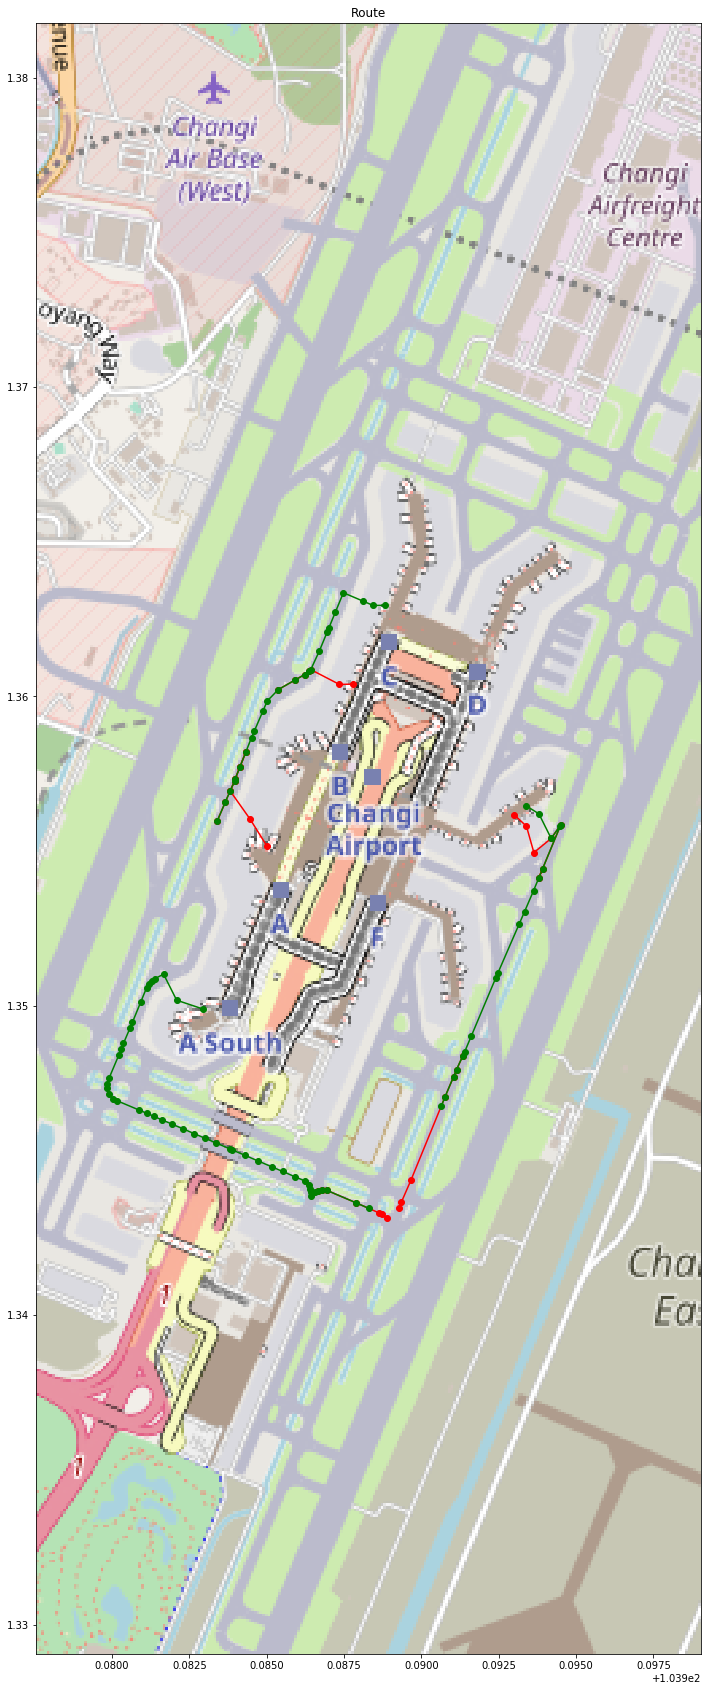

In [106]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 9

Iteration: 9 starts at 321.90 seconds
Current active aircraft time window: 321.90 to 921.90 seconds
Adding aircraft 6 with scheduled departure time 900 to the active list
Adding aircraft 7 with scheduled departure time 900 to the active list
Adding aircraft 8 with scheduled departure time 900 to the active list
Current active aircraft: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Current Execution Horizon Length (in seconds): 20.43599999999998
Executing solutions from  321.904 to 342.34

Finding terminal position at the end of current horizon for aircraft 0
Planned: [321.904, 329.804, 332.149, 335.869, 339.379, 342.34]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [321.904, 378.982, 396.769, 401.0, 418.708, 428.281]
End time of current horizon: 342.34 seconds
Aircraft 1 is in the middle of move 1

Finding terminal position at the end of current horizon for aircraft 2
Planned time: [321.904, 343.243, 354.087, 381

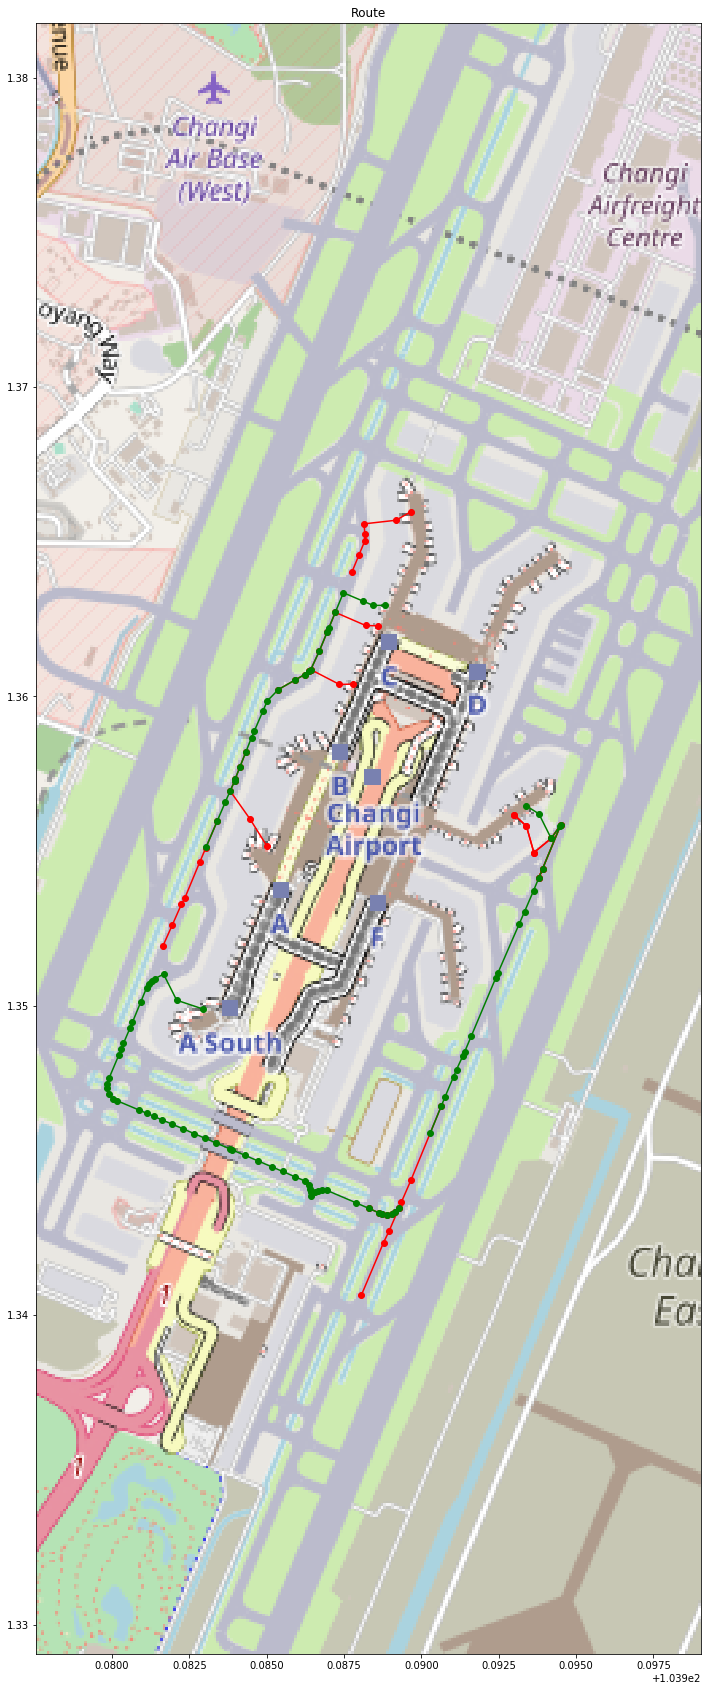

In [107]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1

### Iteration 10

Iteration: 10 starts at 342.34 seconds
Current active aircraft time window: 342.34 to 942.34 seconds
Current active aircraft: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Current Execution Horizon Length (in seconds): 16.085000000000036
Executing solutions from  342.34 to 358.425

Finding terminal position at the end of current horizon for aircraft 0
Planned: [342.34, 346.571, 350.122, 352.203, 354.58, 358.425]
Aircraft 0 is right at the end of all planned moves

Finding terminal position at the end of current horizon for aircraft 1
Planned time: [342.34, 378.982, 384.115, 388.598, 394.166, 405.502]
End time of current horizon: 358.43 seconds
Aircraft 1 is in the middle of move 1

Finding terminal position at the end of current horizon for aircraft 2
Planned time: [342.34, 343.243, 354.087, 381.868, 386.91, 403.17]
End time of current horizon: 358.43 seconds
Aircraft 2 is in the middle of move 3

Finding terminal position at the end of current horizon for aircraft 3
Planned: [600.0, 611.921, 631.595, 6

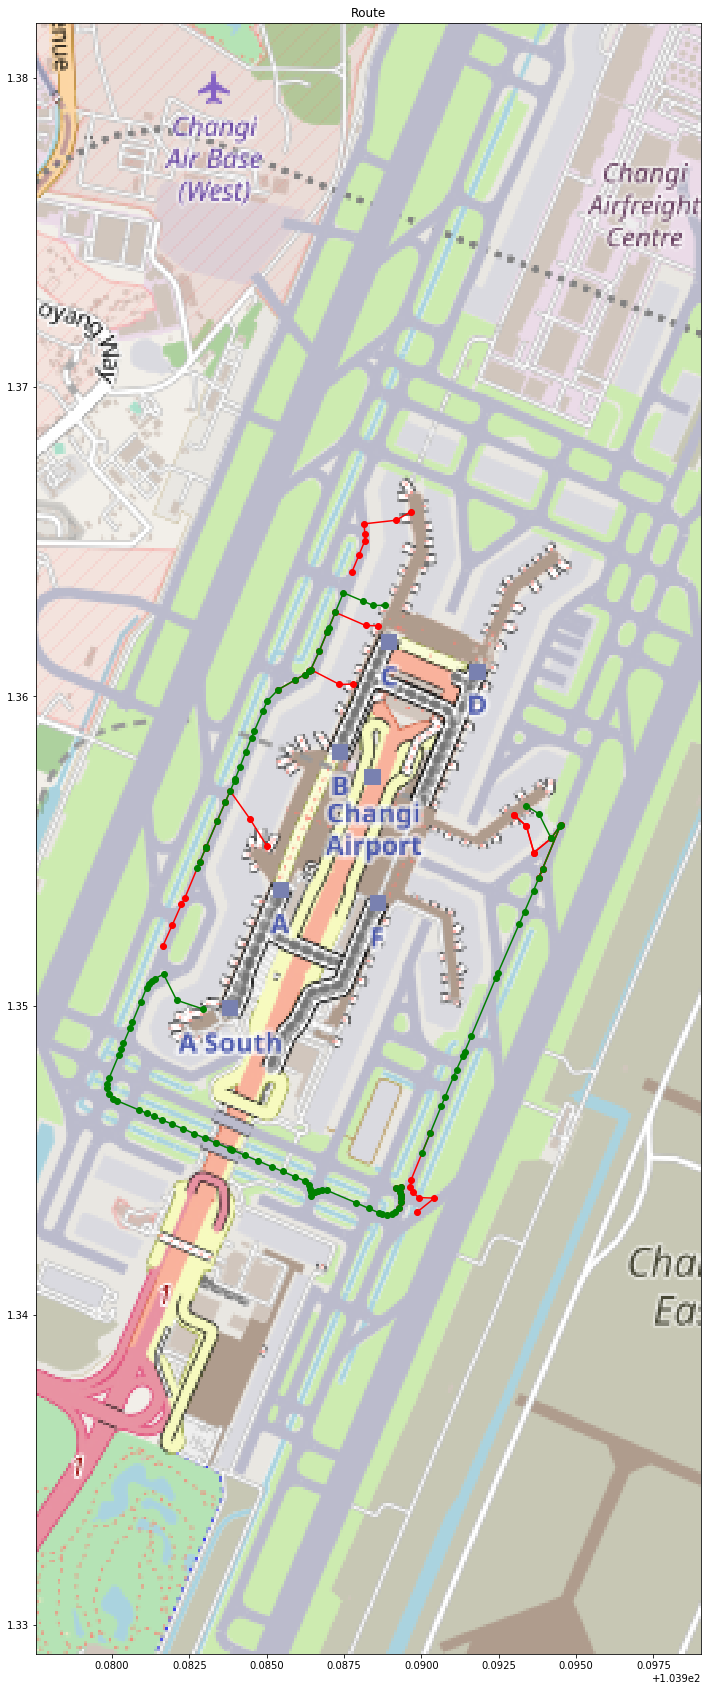

In [108]:
## for each iteration
print("Iteration:", iteration + 1, "starts at {0:0.2f} seconds".format(curr_horizon_start))
print("Current active aircraft time window: {0:0.2f}".format(curr_horizon_start) +
      " to {0:0.2f} seconds".format(curr_horizon_start + WINDOW_SIZE))

# simulate uncertainties
node_conn_idx = random_event_simulator(iteration, node_conn_idx)

# update active aircraft list
A, aircraft_route = update_active_aircraft(
    curr_horizon_start, # start time of current horizon
    WINDOW_SIZE, # length of active aircraft window
    A, # set of all nodes
    scheduled_departure_time, # aircraft scheduled departure time
    aircraft_route, # active aircraft executed route
    DEP_R # final departure runway node
)

print("Current active aircraft:", A)
    
# optimize model
solution = optimize_model(
    iteration, # current iteration
    NUM_OF_MOVES, # number of planning moves in one planning horizon
    A, N, K, SE, # domains
    node_conn_idx, # node connectivity
    L, # node distance
    dist_matrix, # shortest distance
    n_0, n_m1, t_0, # start node, last node before start node, start time of aircraft in current horizon
    t_start,
    V, # speed limit
    D_SEP, # minimal separation distance
    DEP_R # final departure node
)

# execute planned route within the exeution horizon
curr_horizon_start, aircraft_route, planned_route, n_0, n_m1, t_0, N, node_conn_idx, L, v_coord, time_at_node \
= execute_sol(
    solution, 
    curr_horizon_start,
    A, aircraft_route,
    n_0, n_m1, t_0,
    K, N, 
    node_conn_idx, 
    L, v_coord, 
    V, DEP_R 
)

SE = detect_potential_conflicts(planned_route, A, time_at_node)

# print executed and planned routes
for a in A:
    print("\n>> Aircraft", a, "route:")
    if a in aircraft_route.keys():
        print("Executed:", aircraft_route[a])  
    if a in planned_route.keys():
        print("Planned:", planned_route[a])

# visualise routes on the map
plot_route(aircraft_route, planned_route, A)

iteration += 1